# Análisis Estadístico de Retrasos en Vuelos 
## Proyecto Final - Métodos Estadísticos Básicos
### Héctor Gabriel Sánchez Pérez

**Dataset:** Airline Flight Delays (Maven Analytics - US DOT - 2015)  
**Registros:** ~6 millones de vuelos  
**Objetivo:** Aplicar métodos estadísticos para analizar patrones de retrasos, identificar factores asociados y construir modelos predictivos.

https://github.com/cfocoder/trabajo_final_estadistica1_maestria.git


---

### Preguntas de Investigación

1. ¿Existen diferencias significativas en los retrasos promedio entre aerolíneas?
2. ¿Los retrasos muestran patrones temporales (días de la semana, meses)?
3. ¿Qué días de la semana tienen mayor probabilidad de retrasos en las salidas?
4. ¿Cuál es el aeropuerto con más salidas retrasadas y cuál es el motivo de cancelación más frecuente?
5. ¿Qué factores están asociados con las cancelaciones?
6. ¿Podemos predecir la probabilidad de retraso basándonos en características del vuelo?

## 1. Preparación del Entorno

Importación de librerías necesarias para el análisis estadístico completo.

In [2]:
# Manipulación de datos
import ibis
from ibis import _
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Análisis estadístico
from scipy import stats
from scipy.stats import norm, binom, poisson, chi2_contingency, f_oneway
import statsmodels.api as sm

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10

# Importar librerías necesarias para regresión logística
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_score, recall_score, f1_score

# Suprimir advertencias
import warnings
warnings.filterwarnings('ignore')

print("Librerías importadas correctamente")

Librerías importadas correctamente


Todas las herramientas estadísticas están listas. **Ibis nos permitirá trabajar eficientemente con los 6 millones de registros.**

### ¿Por qué Ibis en lugar de Pandas para datasets grandes?

**Ventajas de Ibis:**

1. **Evaluación Perezosa (Lazy Evaluation):** Ibis no carga los datos en memoria hasta que sea necesario. Las operaciones se compilan en consultas SQL optimizadas que se ejecutan directamente en el motor de base de datos (DuckDB en nuestro caso), procesando solo lo necesario.

2. **Gestión Eficiente de Memoria:** Pandas carga todo el dataset en RAM, lo que con 6 millones de filas puede consumir varios GB de memoria y causar problemas de rendimiento. Ibis procesa los datos "out-of-core", trabajando directamente con el archivo en disco.

3. **Optimización Automática:** El motor DuckDB optimiza las consultas automáticamente, utilizando técnicas como paralelización, vectorización y predicado pushdown para maximizar el rendimiento.

4. **API Familiar:** Ibis mantiene una sintaxis similar a Pandas (`.select()`, `.filter()`, `.group_by()`, `.aggregate()`), facilitando la transición sin sacrificar rendimiento.

5. **Escalabilidad:** A diferencia de Pandas que tiene límites claros de RAM, Ibis puede trabajar con datasets que exceden la memoria disponible, haciéndolo ideal para análisis de Big Data.

En este proyecto, Ibis nos permite realizar análisis estadísticos complejos sobre 6 millones de registros de forma fluida, algo que sería considerablemente más lento o incluso inviable con Pandas puro.

## Configuración Interactiva de Ibis

Activamos el modo interactivo de Ibis para visualizar automáticamente los resultados de las consultas sin necesidad de usar `.execute()` explícitamente.

In [3]:
ibis.options.interactive = True 

## 2. Carga y Preparación de Datos

Cargamos las 4 tablas parquet y las unimos en una tabla consolidada para el análisis.

Bajar las tablas desde HuggingFace y guardar en local:

* https://huggingface.co/datasets/hsanchezp/us-dot-flight-delays-2015/resolve/main/flights.parquet

* https://huggingface.co/datasets/hsanchezp/us-dot-flight-delays-2015/resolve/main/airlines.parquet

* https://huggingface.co/datasets/hsanchezp/us-dot-flight-delays-2015/resolve/main/airports.parquet

* https://huggingface.co/datasets/hsanchezp/us-dot-flight-delays-2015/resolve/main/airports.parquet

 * https://huggingface.co/datasets/hsanchezp/us-dot-flight-delays-2015/resolve/main/cancellation_codes.parquet


In [4]:
# Conectar a DuckDB e Ibis
con = ibis.duckdb.connect()

# Cargar tablas parquet
flights = con.read_parquet("flights.parquet")
airlines = con.read_parquet("airlines.parquet")
airports_origin = con.read_parquet("airports.parquet")
airports_dest = con.read_parquet("airports.parquet")
cancellation_codes = con.read_parquet("cancellation_codes.parquet")

# Explorar estructura básica
print("Tabla flights:")
print(f"  Filas: {flights.count().execute():,}")
print(f"  Columnas: {len(flights.columns)}")
print(f"\nPrimeras columnas: {flights.columns[:10]}")

Tabla flights:
  Filas: 5,819,079
  Columnas: 31

Primeras columnas: ('YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER', 'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE')


In [5]:
# Visualizamos la tabla airlines
airlines 

┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ IATA_CODE ┃ AIRLINE                ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ string    │ string                 │
├───────────┼────────────────────────┤
│ UA        │ United Air Lines Inc.  │
│ AA        │ American Airlines Inc. │
│ US        │ US Airways Inc.        │
│ F9        │ Frontier Airlines Inc. │
│ B6        │ JetBlue Airways        │
│ OO        │ Skywest Airlines Inc.  │
│ AS        │ Alaska Airlines Inc.   │
│ NK        │ Spirit Air Lines       │
│ WN        │ Southwest Airlines Co. │
│ DL        │ Delta Air Lines Inc.   │
│ …         │ …                      │
└───────────┴────────────────────────┘

In [6]:
# visualizamos la tabla de airports

airports_origin

┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ IATA_CODE ┃ AIRPORT                             ┃ CITY          ┃ STATE  ┃ COUNTRY ┃ LATITUDE ┃ LONGITUDE  ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━┩
│ string    │ string                              │ string        │ string │ string  │ float64  │ float64    │
├───────────┼─────────────────────────────────────┼───────────────┼────────┼─────────┼──────────┼────────────┤
│ ABE       │ Lehigh Valley International Airport │ Allentown     │ PA     │ USA     │ 40.65236 │  -75.44040 │
│ ABI       │ Abilene Regional Airport            │ Abilene       │ TX     │ USA     │ 32.41132 │  -99.68190 │
│ ABQ       │ Albuquerque International Sunport   │ Albuquerque   │ NM     │ USA     │ 35.04022 │ -106.60919 │
│ ABR       │ Aberdeen Regional Airport           │ Aberdeen      │ SD     │ USA     │ 45.44906 │  -98.42183 │
│ ABY       │ Southwest Georgia Regional Airport  │ Albany        │ GA     │ USA     │ 31.53552 │  -84.19447 │
│ ACK       │ Nantucket Memorial Airport          │ Nantucket     │ MA     │ USA     │ 41.25305 │  -70.06018 │
│ ACT       │ Waco Regional Airport               │ Waco          │ TX     │ USA     │ 31.61129 │  -97.23052 │
│ ACV       │ Arcata Airport                      │ Arcata/Eureka │ CA     │ USA     │ 40.97812 │ -124.10862 │
│ ACY       │ Atlantic City International Airport │ Atlantic City │ NJ     │ USA     │ 39.45758 │  -74.57717 │
│ ADK       │ Adak Airport                        │ Adak          │ AK     │ USA     │ 51.87796 │ -176.64603 │
│ …         │ …                                   │ …             │ …      │ …       │        … │          … │
└───────────┴─────────────────────────────────────┴───────────────┴────────┴─────────┴──────────┴────────────┘

In [7]:
# visualizamos la tabla de cancellation codes 
cancellation_codes

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ CANCELLATION_REASON ┃ CANCELLATION_DESCRIPTION ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ string              │ string                   │
├─────────────────────┼──────────────────────────┤
│ A                   │ Airline/Carrier          │
│ B                   │ Weather                  │
│ C                   │ National Air System      │
│ D                   │ Security                 │
└─────────────────────┴──────────────────────────┘

La tabla principal contiene millones de registros. Verificamos la estructura antes de unir las tablas.

In [8]:
# Tabla principal

flights

┏━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ YEAR  ┃ MONTH ┃ DAY   ┃ DAY_OF_WEEK ┃ AIRLINE ┃ FLIGHT_NUMBER ┃ TAIL_NUMBER ┃ ORIGIN_AIRPORT ┃ DESTINATION_AIRPORT ┃ SCHEDULED_DEPARTURE ┃ DEPARTURE_TIME ┃ DEPARTURE_DELAY ┃ TAXI_OUT ┃ WHEELS_OFF ┃ SCHEDULED_TIME ┃ ELAPSED_TIME ┃ AIR_TIME ┃ DISTANCE ┃ WHEELS_ON ┃ TAXI_IN ┃ SCHEDULED_ARRIVAL ┃ ARRIVAL_TIME ┃ ARRIVAL_DELAY ┃ DIVERTED ┃ CANCELLED ┃ CANCELLATION_REASON ┃ AIR_SYSTEM_DELAY ┃ SECURITY_DELAY ┃ AIRLINE_DELAY ┃ LATE_AIRCRAFT_DELAY ┃ WEATHER_DELAY ┃
┡━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ int64 │ int64 │ int64 │ int64       │ string  │ int64         │ string      │ string         │ string              │ string              │ string         │ int64           │ int64    │ string     │ int64          │ int64        │ int64    │ int64    │ string    │ int64   │ string            │ string       │ int64         │ int64    │ int64     │ string              │ int64            │ int64          │ int64         │ int64               │ int64         │
├───────┼───────┼───────┼─────────────┼─────────┼───────────────┼─────────────┼────────────────┼─────────────────────┼─────────────────────┼────────────────┼─────────────────┼──────────┼────────────┼────────────────┼──────────────┼──────────┼──────────┼───────────┼─────────┼───────────────────┼──────────────┼───────────────┼──────────┼───────────┼─────────────────────┼──────────────────┼────────────────┼───────────────┼─────────────────────┼───────────────┤
│  2015 │     1 │     1 │           4 │ AS      │            98 │ N407AS      │ ANC            │ SEA                 │ 0005                │ 2354           │             -11 │       21 │ 0015       │            205 │          194 │      169 │     1448 │ 0404      │       4 │ 0430              │ 0408         │           -22 │        0 │         0 │ NULL                │             NULL │           NULL │          NULL │                NULL │          NULL │
│  2015 │     1 │     1 │           4 │ AA      │          2336 │ N3KUAA      │ LAX            │ PBI                 │ 0010                │ 0002           │              -8 │       12 │ 0014       │            280 │          279 │      263 │     2330 │ 0737      │       4 │ 0750              │ 0741         │            -9 │        0 │         0 │ NULL                │             NULL │           NULL │          NULL │                NULL │          NULL │
│  2015 │     1 │     1 │           4 │ US      │           840 │ N171US      │ SFO            │ CLT                 │ 0020                │ 0018           │              -2 │       16 │ 0034       │            286 │          293 │      266 │     2296 │ 0800      │      11 │ 0806              │ 0811         │             5 │        0 │         0 │ NULL                │             NULL │           NULL │          NULL │                NULL │          NULL │
│  2015 │     1 │     1 │           4 │ AA      │           258 │ N3HYAA      │ LAX            │ MIA                 │ 0020                │ 0015           │              -5 │       15 │ 0030       │            285 │          281 │      258 │     2342 │ 0748      │       8 │ 0805              │ 0756    

Unimos todas las tablas en una sola tabla consolidada para facilitar el análisis.

In [9]:
# Unir todas las tablas (nombres de columnas en MAYÚSCULAS)
df_full = (flights
    .left_join(airlines, [_.AIRLINE == airlines.IATA_CODE], rname='{name}_airline')
    .left_join(airports_origin, [('ORIGIN_AIRPORT', 'IATA_CODE')], rname='{name}_origin')
    .left_join(airports_dest, [('DESTINATION_AIRPORT', 'IATA_CODE')], rname='{name}_dest')
    .left_join(cancellation_codes, 'CANCELLATION_REASON', rname='{name}_cancel')
)

# Verificar la unión
print(f"Tabla consolidada - Columnas: {len(df_full.columns)}")
print(f"\nMuestra de columnas clave:")
sample_cols = [c for c in df_full.columns if any(x in c.upper() for x in ['DELAY', 'AIRLINE', 'ORIGIN', 'DEST', 'CANCEL'])][:15]
print(sample_cols)

Tabla consolidada - Columnas: 49

Muestra de columnas clave:
['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'DEPARTURE_DELAY', 'ARRIVAL_DELAY', 'CANCELLED', 'CANCELLATION_REASON', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'AIRLINE_airline', 'IATA_CODE_origin', 'IATA_CODE_dest']


In [10]:
# Visualizamos la tabla combinada de Ibis Framework
df_full 

┏━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ YEAR  ┃ MONTH ┃ DAY   ┃ DAY_OF_WEEK ┃ AIRLINE ┃ FLIGHT_NUMBER ┃ TAIL_NUMBER ┃ ORIGIN_AIRPORT ┃ DESTINATION_AIRPORT ┃ SCHEDULED_DEPARTURE ┃ DEPARTURE_TIME ┃ DEPARTURE_DELAY ┃ TAXI_OUT ┃ WHEELS_OFF ┃ SCHEDULED_TIME ┃ ELAPSED_TIME ┃ AIR_TIME ┃ DISTANCE ┃ WHEELS_ON ┃ TAXI_IN ┃ SCHEDULED_ARRIVAL ┃ ARRIVAL_TIME ┃ ARRIVAL_DELAY ┃ DIVERTED ┃ CANCELLED ┃ CANCELLATION_REASON ┃ AIR_SYSTEM_DELAY ┃ SECURITY_DELAY ┃ AIRLINE_DELAY ┃ LATE_AIRCRAFT_DELAY ┃ WEATHER_DELAY ┃ IATA_CODE ┃ AIRLINE_airline              ┃ IATA_CODE_origin ┃ AIRPORT                                 ┃ CITY              ┃ STATE  ┃ COUNTRY ┃ LATITUDE ┃ LONGITUDE ┃ IATA_CODE_dest ┃ AIRPORT_dest                                                                     ┃ CITY_dest    ┃ STATE_dest ┃ COUNTRY_dest ┃ LATITUDE_dest ┃ LONGITUDE_dest ┃ CANCELLATION_REASON_cancel ┃ CANCELLATION_DESCRIPTION ┃
┡━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ int64 │ int64 │ int64 │ int64       │ string  │ int64         │ string      │ string         │ string              │ string              │ string         │ int64           │ int64    │ string     │ int64          │ int64        │ int64    │ int64    │ string    │ int64   │ string            │ string       │ int64         │ int64    │ int64     │ string              │ int64            │ int64          │ int64         │ int64               │ int64         │ string    │ string                       │ string           │ string                                  │ string            │ string │ string  │ float64  │ float64   │ string         │ string                                                                           │ string       │ string     │ string       │ float64       │ float64        │ string                     │ string                   │
├───────┼───────┼───────┼─────────────┼─────────┼───────────────┼─────────────┼────────────────┼─────────────────────┼─────────────────────┼────────────────┼─────────────────┼──────────┼────────────┼────────────────┼──────────────┼──────────┼──────────┼───────────┼─────────┼───────────────────┼──────────────┼───────────────┼──────────┼───────────┼─────────────────────┼──────────────────┼────────────────┼───────────────┼─────────────────────┼───────────────┼───────────┼──────────────────────────────┼──────────────────┼─────────────────────────────────────

In [11]:
# Verificamos que la tabla combinada siga teniendo el mismo numero de filas
df_full.count()

┌─────────┐
│ 5819079 │
└─────────┘

Tabla consolidada creada exitosamente. Ahora tenemos acceso a toda la información de vuelos, aerolíneas, aeropuertos y razones de cancelación en un solo lugar.

Seleccionamos y preparamos las columnas clave para el análisis.

In [12]:
# Seleccionar columnas clave para el análisis
df_analysis = df_full.select([
    'DAY',
    'MONTH',
    'YEAR',
    'AIRLINE',
    'AIRLINE_airline',
    'ORIGIN_AIRPORT',
    'DESTINATION_AIRPORT',
    'DEPARTURE_DELAY',
    'ARRIVAL_DELAY',
    'DISTANCE',
    'CANCELLED',
    'CANCELLATION_REASON',
    'CANCELLATION_DESCRIPTION'
])

# Ver primeras filas
df_analysis

┏━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ DAY   ┃ MONTH ┃ YEAR  ┃ AIRLINE ┃ AIRLINE_airline              ┃ ORIGIN_AIRPORT ┃ DESTINATION_AIRPORT ┃ DEPARTURE_DELAY ┃ ARRIVAL_DELAY ┃ DISTANCE ┃ CANCELLED ┃ CANCELLATION_REASON ┃ CANCELLATION_DESCRIPTION ┃
┡━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ int64 │ int64 │ int64 │ string  │ string                       │ string         │ string              │ int64           │ int64         │ int64    │ int64     │ string              │ string                   │
├───────┼───────┼───────┼─────────┼──────────────────────────────┼────────────────┼─────────────────────┼─────────────────┼───────────────┼──────────┼───────────┼─────────────────────┼──────────────────────────┤
│     8 │     1 │  2015 │ MQ      │ American Eagle Airlines Inc. │ DFW            │ FWA                 │            NULL │          NULL │      859 │         1 │ B                   │ Weather                  │
│     8 │     1 │  2015 │ MQ      │ American Eagle Airlines Inc. │ MSN            │ ORD                 │            NULL │          NULL │      108 │         1 │ C                   │ National Air System      │
│     8 │     1 │  2015 │ MQ      │ American Eagle Airlines Inc. │ ORD            │ CWA                 │            NULL │          NULL │      212 │         1 │ C                   │ National Air System      │
│     8 │     1 │  2015 │ OO      │ Skywest Airlines Inc.        │ ORD            │ ICT                 │            NULL │          NULL │      588 │         1 │ B                   │ Weather                  │
│     8 │     1 │  2015 │ EV      │ Atlantic Southeast Airlines  │ CLE            │ LGA                 │            NULL │          NULL │      419 │         1 │ B                   │ Weather                  │
│     8 │     1 │  2015 │ EV      │ Atlantic Southeast Airlines  │ ORD            │ ERI                 │            NULL │          NULL │      398 │         1 │ B                   │ Weather                  │
│     8 │     1 │  2015 │ WN      │ Southwest Airlines Co.       │ MCO            │ GRR                 │            NULL │          NULL │     1024 │         1 │ B                   │ Weather                  │
│     8 │     1 │  2015 │ WN      │ Southwest Airlines Co.       │ MDW            │ DCA                 │            NULL │          NULL │      601 │         1 │ A                   │ Airline/Carrier          │
│     8 │     1 │  2015 │ WN      │ Southwest Airlines Co.       │ MDW            │ ICT                 │            NULL │          NULL │      589 │         1 │ B                   │ Weather                  │
│     8 │     1 │  2015 │ EV      │ Atlantic Southeast Airlines  │ ORD            │ CAK                 │            NULL │          NULL │      343 │         1 │ B                   │ Weather                  │
│     … │     … │     … │ …       │ …                            │ …              │ …                   │               … │             … │        … │         … │ …                   │ …                        │
└───────┴───────┴───────┴─────────┴──────────────────────────────┴────────────────┴─────────────────────┴─────────────────┴───────────────┴──────────┴───────────┴─────────────────────┴──────────────────────────┘

Datos seleccionados y estructurados. Observamos las columnas principales: fechas, aerolíneas, retrasos de salida/llegada, distancia y estado de cancelación.

## 3. Estadística Descriptiva

### 3.1 Medidas de Tendencia Central y Dispersión

Calculamos las principales medidas estadísticas para los retrasos de salida.

In [13]:
# Estadísticas descriptivas básicas con Ibis
delay_col = 'DEPARTURE_DELAY'

stats_desc = df_analysis.aggregate([
    df_analysis[delay_col].count().name('n_vuelos'),
    df_analysis[delay_col].mean().name('media'),
    df_analysis[delay_col].std().name('desviacion_std'),
    df_analysis[delay_col].var().name('varianza'),
    df_analysis[delay_col].min().name('minimo'),
    df_analysis[delay_col].quantile(0.25).name('Q1'),
    df_analysis[delay_col].quantile(0.50).name('mediana'),
    df_analysis[delay_col].quantile(0.75).name('Q3'),
    df_analysis[delay_col].max().name('maximo')
]).execute()

print("=== ESTADÍSTICAS DESCRIPTIVAS: RETRASO DE SALIDA (minutos) ===\n")
for col in stats_desc.columns:
    val = stats_desc[col].iloc[0]
    if col == 'n_vuelos':
        print(f"{col:20s}: {val:,.0f}")
    else:
        print(f"{col:20s}: {val:,.2f}")

# Calcular medidas adicionales
media = stats_desc['media'].iloc[0]
desv_std = stats_desc['desviacion_std'].iloc[0]
coef_var = (desv_std / media) * 100 if media != 0 else 0
IQR = stats_desc['Q3'].iloc[0] - stats_desc['Q1'].iloc[0]

print(f"\n{'Coef. Variación':20s}: {coef_var:.2f}%")
print(f"{'Rango Intercuartil':20s}: {IQR:.2f}")

=== ESTADÍSTICAS DESCRIPTIVAS: RETRASO DE SALIDA (minutos) ===

n_vuelos            : 5,732,926
media               : 9.37
desviacion_std      : 37.08
varianza            : 1,375.00
minimo              : -82.00
Q1                  : -5.00
mediana             : -2.00
Q3                  : 7.00
maximo              : 1,988.00

Coef. Variación     : 395.73%
Rango Intercuartil  : 12.00


**Interpretación:**

Con 5,732,926 vuelos analizados:

- **Tendencia central**: Media=9.37 min, pero mediana=-2.00 min. Más del 50% de vuelos salen adelantados o a tiempo. La diferencia indica que retrasos extremos elevan el promedio.

- **Variabilidad**: CV=395.73% (muy alto). Desviación estándar (37.08 min) es 4× la media, mostrando alta dispersión y difícil predicción.

- **Asimetría**: IQR=12 min (Q1=-5, Q3=7), pero máximo=1,988 min (~33 horas). Distribución sesgada a la derecha con cola larga de retrasos extremos.

- **Conclusión**: Bajo condiciones normales, 50% central opera dentro de 12 minutos del horario. Los problemas se concentran en un subconjunto con retrasos severos.

### 3.2 Asimetría y Curtosis

Evaluamos la forma de la distribución de retrasos.

=== FORMA DE LA DISTRIBUCIÓN ===

Asimetría (Skewness): 7.593
  → Distribución sesgada a la derecha (cola derecha más larga)

Curtosis: 123.006
  → Leptocúrtica (más apuntada que la normal, colas pesadas)


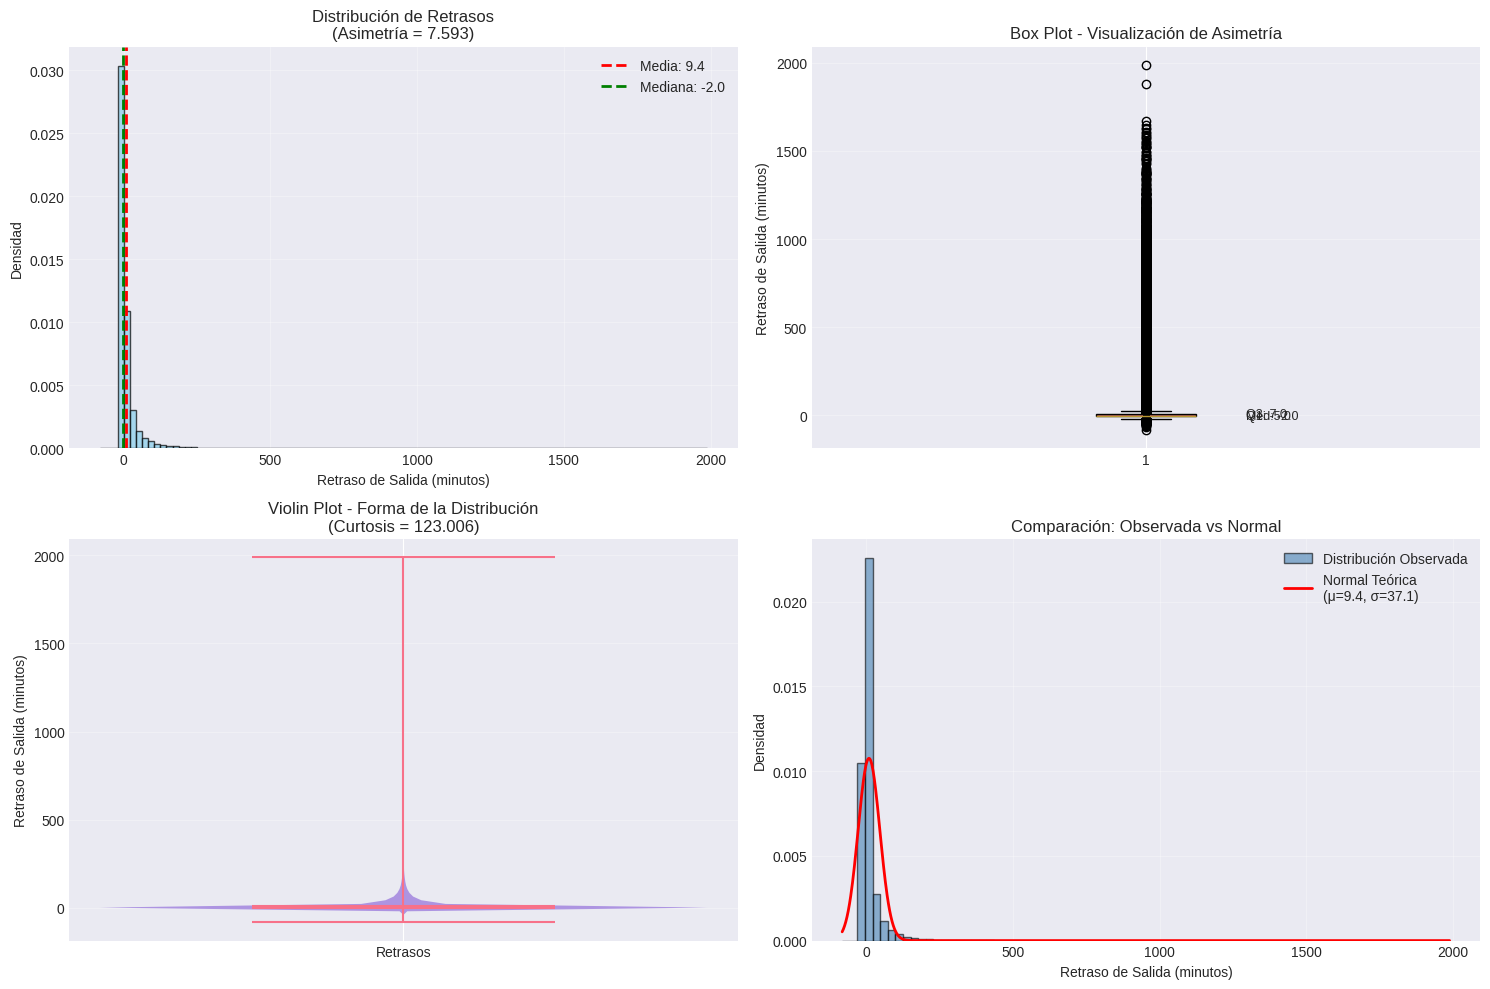


=== INTERPRETACIÓN VISUAL ===
• El histograma muestra la cola derecha extendida (asimetría positiva)
• El box plot evidencia la presencia de outliers superiores
• El violin plot ilustra el pico pronunciado (leptocúrtica)
• La comparación muestra clara desviación de la distribución normal


In [14]:
# Convertir a pandas para cálculos de asimetría y curtosis

# Limpiar datos (remover nulos)
delay_data = (
    df_analysis
    .filter(df_analysis[delay_col].notnull())
    .select(f"{delay_col}")
).execute().squeeze()

# Calcular asimetría y curtosis
skewness = stats.skew(delay_data)
kurt = stats.kurtosis(delay_data)

print(f"=== FORMA DE LA DISTRIBUCIÓN ===\n")
print(f"Asimetría (Skewness): {skewness:.3f}")
if skewness > 0:
    print("  → Distribución sesgada a la derecha (cola derecha más larga)")
elif skewness < 0:
    print("  → Distribución sesgada a la izquierda (cola izquierda más larga)")
else:
    print("  → Distribución simétrica")

print(f"\nCurtosis: {kurt:.3f}")
if kurt > 0:
    print("  → Leptocúrtica (más apuntada que la normal, colas pesadas)")
elif kurt < 0:
    print("  → Platicúrtica (más achatada que la normal)")
else:
    print("  → Mesocúrtica (similar a la distribución normal)")

# Visualización de la distribución
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Histograma con curva de densidad
axes[0, 0].hist(delay_data, bins=100, density=True, alpha=0.7, edgecolor='black', color='skyblue')
axes[0, 0].set_xlabel('Retraso de Salida (minutos)')
axes[0, 0].set_ylabel('Densidad')
axes[0, 0].set_title(f'Distribución de Retrasos\n(Asimetría = {skewness:.3f})')
axes[0, 0].axvline(delay_data.mean(), color='red', linestyle='--', linewidth=2, label=f'Media: {delay_data.mean():.1f}')
axes[0, 0].axvline(delay_data.median(), color='green', linestyle='--', linewidth=2, label=f'Mediana: {delay_data.median():.1f}')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Box plot para visualizar asimetría
bp = axes[0, 1].boxplot(delay_data, vert=True, patch_artist=True)
bp['boxes'][0].set_facecolor('lightcoral')
axes[0, 1].set_ylabel('Retraso de Salida (minutos)')
axes[0, 1].set_title('Box Plot - Visualización de Asimetría')
axes[0, 1].grid(alpha=0.3, axis='y')
# Añadir estadísticas
q1, median, q3 = delay_data.quantile([0.25, 0.5, 0.75])
axes[0, 1].text(1.15, q1, f'Q1: {q1:.1f}', fontsize=9, va='center')
axes[0, 1].text(1.15, median, f'Med: {median:.1f}', fontsize=9, va='center')
axes[0, 1].text(1.15, q3, f'Q3: {q3:.1f}', fontsize=9, va='center')

# 3. Violin plot para visualizar forma completa
parts = axes[1, 0].violinplot([delay_data], positions=[1], showmeans=True, showmedians=True)
for pc in parts['bodies']:
    pc.set_facecolor('mediumpurple')
    pc.set_alpha(0.7)
axes[1, 0].set_ylabel('Retraso de Salida (minutos)')
axes[1, 0].set_title(f'Violin Plot - Forma de la Distribución\n(Curtosis = {kurt:.3f})')
axes[1, 0].set_xticks([1])
axes[1, 0].set_xticklabels(['Retrasos'])
axes[1, 0].grid(alpha=0.3, axis='y')

# 4. Diagrama comparativo: Normal vs Observada
axes[1, 1].hist(delay_data, bins=80, density=True, alpha=0.6, color='steelblue', 
               edgecolor='black', label='Distribución Observada')
# Superponer distribución normal teórica
mu, sigma = delay_data.mean(), delay_data.std()
x = np.linspace(delay_data.min(), delay_data.max(), 1000)
axes[1, 1].plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, 
               label=f'Normal Teórica\n(μ={mu:.1f}, σ={sigma:.1f})')
axes[1, 1].set_xlabel('Retraso de Salida (minutos)')
axes[1, 1].set_ylabel('Densidad')
axes[1, 1].set_title('Comparación: Observada vs Normal')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Interpretación visual
print("\n=== INTERPRETACIÓN VISUAL ===")
print(f"• El histograma muestra la cola derecha extendida (asimetría positiva)")
print(f"• El box plot evidencia la presencia de outliers superiores")
print(f"• El violin plot ilustra el pico pronunciado (leptocúrtica)")
print(f"• La comparación muestra clara desviación de la distribución normal")

**Asimetría (7.593)**: Sesgo extremadamente positivo. La mayoría de vuelos salen a tiempo (mediana=-2.0 min), pero existe una cola larga de retrasos severos hasta 2000+ minutos. El histograma y violin plot muestran pico central estrecho con cola derecha extendida.

**Curtosis (123.006)**: Distribución leptocúrtica muy pronunciada (normal=3). El box plot evidencia miles de outliers superiores, confirmando colas pesadas. La comparación con la curva normal muestra desviación radical.

**Conclusión**: Distribución no normal. Mayoría de vuelos puntuales, pero cuando hay retrasos son extremos, sugiriendo efectos en cascada operacionales.

### 3.3 Identificación de Valores Atípicos (Outliers)

Usamos el método del rango intercuartil (IQR) para detectar outliers.

=== DETECCIÓN DE VALORES ATÍPICOS (Método IQR) ===

Límite inferior: -23.00 minutos
Límite superior: 25.00 minutos

Outliers inferiores: 1,247 (0.02%)
Outliers superiores: 734,995 (12.82%)
Total outliers: 736,242 (12.84%)


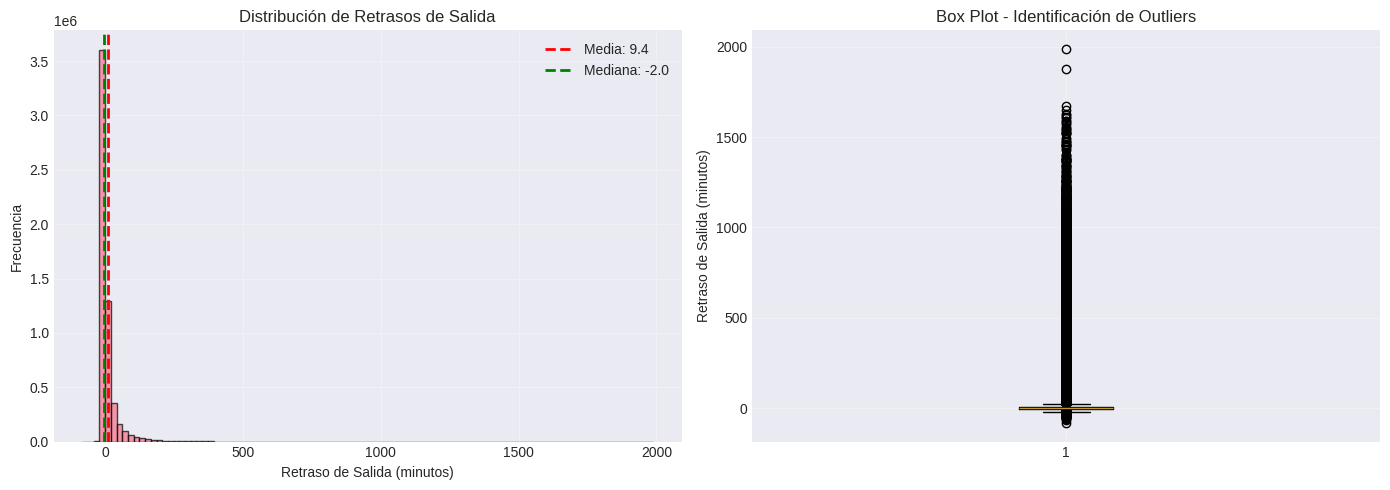

In [15]:
# Método IQR para outliers
Q1 = stats_desc['Q1'].iloc[0]
Q3 = stats_desc['Q3'].iloc[0]
IQR = Q3 - Q1

# Límites para outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Contar outliers en el dataset completo
outliers_lower = (delay_data < lower_bound).sum()
outliers_upper = (delay_data > upper_bound).sum()
total_outliers = outliers_lower + outliers_upper
pct_outliers = (total_outliers / len(delay_data)) * 100

print(f"=== DETECCIÓN DE VALORES ATÍPICOS (Método IQR) ===\n")
print(f"Límite inferior: {lower_bound:.2f} minutos")
print(f"Límite superior: {upper_bound:.2f} minutos")
print(f"\nOutliers inferiores: {outliers_lower:,} ({outliers_lower/len(delay_data)*100:.2f}%)")
print(f"Outliers superiores: {outliers_upper:,} ({outliers_upper/len(delay_data)*100:.2f}%)")
print(f"Total outliers: {total_outliers:,} ({pct_outliers:.2f}%)")

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma
axes[0].hist(delay_data, bins=100, edgecolor='black', alpha=0.7)
axes[0].axvline(media, color='red', linestyle='--', linewidth=2, label=f'Media: {media:.1f}')
axes[0].axvline(stats_desc['mediana'].iloc[0], color='green', linestyle='--', linewidth=2, label=f'Mediana: {stats_desc["mediana"].iloc[0]:.1f}')
axes[0].set_xlabel('Retraso de Salida (minutos)')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Distribución de Retrasos de Salida')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Box plot
axes[1].boxplot(delay_data, vert=True)
axes[1].set_ylabel('Retraso de Salida (minutos)')
axes[1].set_title('Box Plot - Identificación de Outliers')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

El análisis IQR detectó **736,242 outliers (12.84%)** de los vuelos. El histograma muestra una concentración masiva de datos cerca de cero (mediana=-2.0 min), mientras que el box plot evidencia una situación llamativa: la caja es extremadamente pequeña (Q1=-14 min, Q3=11 min, IQR=25 min) y está rodeada por **734,995 outliers superiores** que forman una columna densa hasta los 2,000 minutos. Esto confirma que aunque la mayoría de vuelos son puntuales, existe una proporción significativa de retrasos extremos (>25 min) que distorsionan la distribución.

### 3.4 Análisis por Aerolínea

Comparamos el desempeño de diferentes aerolíneas usando estadística descriptiva.

=== TOP 10 AEROLÍNEAS ORDENADAS POR RETRASO PROMEDIO ===



,Aerolínea,Código,N° Vuelos,Retraso Promedio (min),Desv. Std.,Mediana (min)
0,Spirit Air Lines,NK,"117,379",15.94,43.77,-1.00
1,United Air Lines Inc.,UA,"515,723",14.44,42.06,1.00
2,Frontier Airlines Inc.,F9,"90,836",13.35,49.51,-2.00
3,JetBlue Airways,B6,"267,048",11.51,38.52,-2.00
4,Southwest Airlines Co.,WN,"1,261,855",10.58,30.74,0.00
5,American Eagle Airlines Inc.,MQ,"294,632",10.13,40.62,-2.00
6,Virgin America,VX,"61,903",9.02,32.42,-1.00
7,American Airlines Inc.,AA,"725,984",8.90,41.90,-2.00
8,Atlantic Southeast Airlines,EV,"571,977",8.72,38.68,-3.00
9,Skywest Airlines Inc.,OO,"588,353",7.80,37.81,-3.00


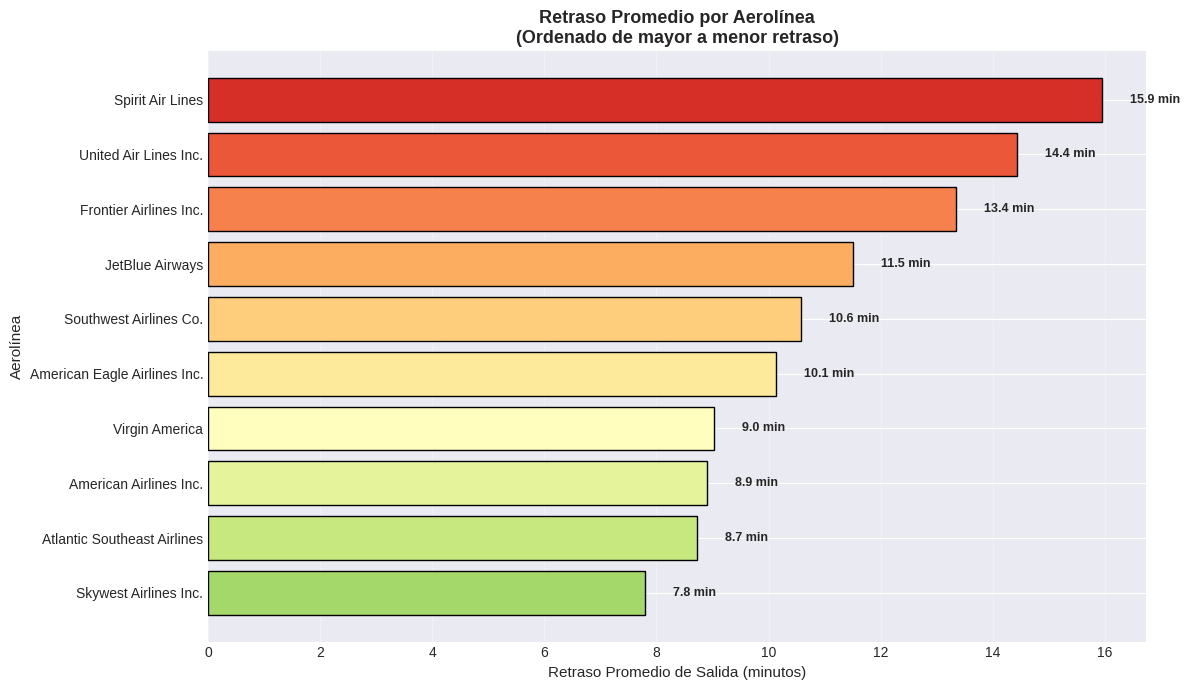


📊 Resumen:
• Aerolínea con MAYOR retraso promedio: Spirit Air Lines (15.94 min)
• Aerolínea con MENOR retraso promedio: Skywest Airlines Inc. (7.80 min)
• Diferencia: 8.14 minutos


In [16]:
# Estadísticas por aerolínea (con nombres completos)
stats_by_airline = (df_analysis
    .group_by(['AIRLINE', 'AIRLINE_airline'])
    .aggregate([
        _.count().name('n_vuelos'),
        _[delay_col].mean().name('retraso_promedio'),
        _[delay_col].std().name('desv_std'),
        _[delay_col].quantile(0.50).name('mediana')
    ])
    .order_by(ibis.desc('retraso_promedio'))
    .limit(10)
    .execute()
)

# Crear tabla para visualización
display_table = stats_by_airline[[
    'AIRLINE_airline', 'AIRLINE', 'n_vuelos', 'retraso_promedio', 'desv_std', 'mediana'
]].copy()
display_table.columns = ['Aerolínea', 'Código', 'N° Vuelos', 'Retraso Promedio (min)', 'Desv. Std.', 'Mediana (min)']

print("=== TOP 10 AEROLÍNEAS ORDENADAS POR RETRASO PROMEDIO ===\n")
display(display_table.style.format({
    'N° Vuelos': '{:,.0f}',
    'Retraso Promedio (min)': '{:.2f}',
    'Desv. Std.': '{:.2f}',
    'Mediana (min)': '{:.2f}'
}).background_gradient(subset=['Retraso Promedio (min)'], cmap='YlOrRd'))

# Visualización ordenada por retraso promedio
fig, ax = plt.subplots(figsize=(12, 7))

# Usar nombres de aerolíneas en lugar de códigos (invertir orden para que mayor quede arriba)
airline_names_list = stats_by_airline['AIRLINE_airline'].tolist()[::-1]
delays = stats_by_airline['retraso_promedio'].tolist()[::-1]

# Crear colores degradados según el retraso (del más bajo al más alto en la lista invertida)
colors = plt.cm.RdYlGn_r(np.linspace(0.3, 0.9, len(delays)))

bars = ax.barh(airline_names_list, delays, color=colors, edgecolor='black')
ax.set_xlabel('Retraso Promedio de Salida (minutos)', fontsize=11)
ax.set_ylabel('Aerolínea', fontsize=11)
ax.set_title('Retraso Promedio por Aerolínea\n(Ordenado de mayor a menor retraso)', fontsize=13, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Añadir valores en las barras
for i, (bar, val) in enumerate(zip(bars, delays)):
    ax.text(val + 0.5, bar.get_y() + bar.get_height()/2, 
            f'{val:.1f} min', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# Resumen estadístico
print(f"\n📊 Resumen:")
print(f"• Aerolínea con MAYOR retraso promedio: {stats_by_airline.iloc[0]['AIRLINE_airline']} ({stats_by_airline.iloc[0]['retraso_promedio']:.2f} min)")
print(f"• Aerolínea con MENOR retraso promedio: {stats_by_airline.iloc[-1]['AIRLINE_airline']} ({stats_by_airline.iloc[-1]['retraso_promedio']:.2f} min)")
print(f"• Diferencia: {stats_by_airline.iloc[0]['retraso_promedio'] - stats_by_airline.iloc[-1]['retraso_promedio']:.2f} minutos")

### 3.5 Análisis de Aeropuertos: Retrasos y Motivos de Cancelación

**Pregunta:** ¿Cuál es el aeropuerto con más salidas con retraso y cuál es el motivo más frecuente de cancelación?

Analizamos los aeropuertos de origen para identificar aquellos con mayor número de vuelos retrasados y los motivos de cancelación más comunes.

=== TOP 10 AEROPUERTOS CON MÁS SALIDAS RETRASADAS ===



,Aeropuerto,Vuelos Retrasados,Retraso Promedio (min),Desv. Std.
0,ATL,"129,846",29.33,47.21
1,ORD,"121,706",37.21,53.08
2,DFW,"96,475",33.50,48.60
3,DEN,"89,290",30.49,45.43
4,LAX,"81,954",30.44,47.51
5,IAH,"61,360",33.01,49.43
6,PHX,"59,960",26.78,42.11
7,SFO,"58,755",34.18,53.00
8,LAS,"57,031",30.95,49.75
9,EWR,"44,723",35.28,51.69


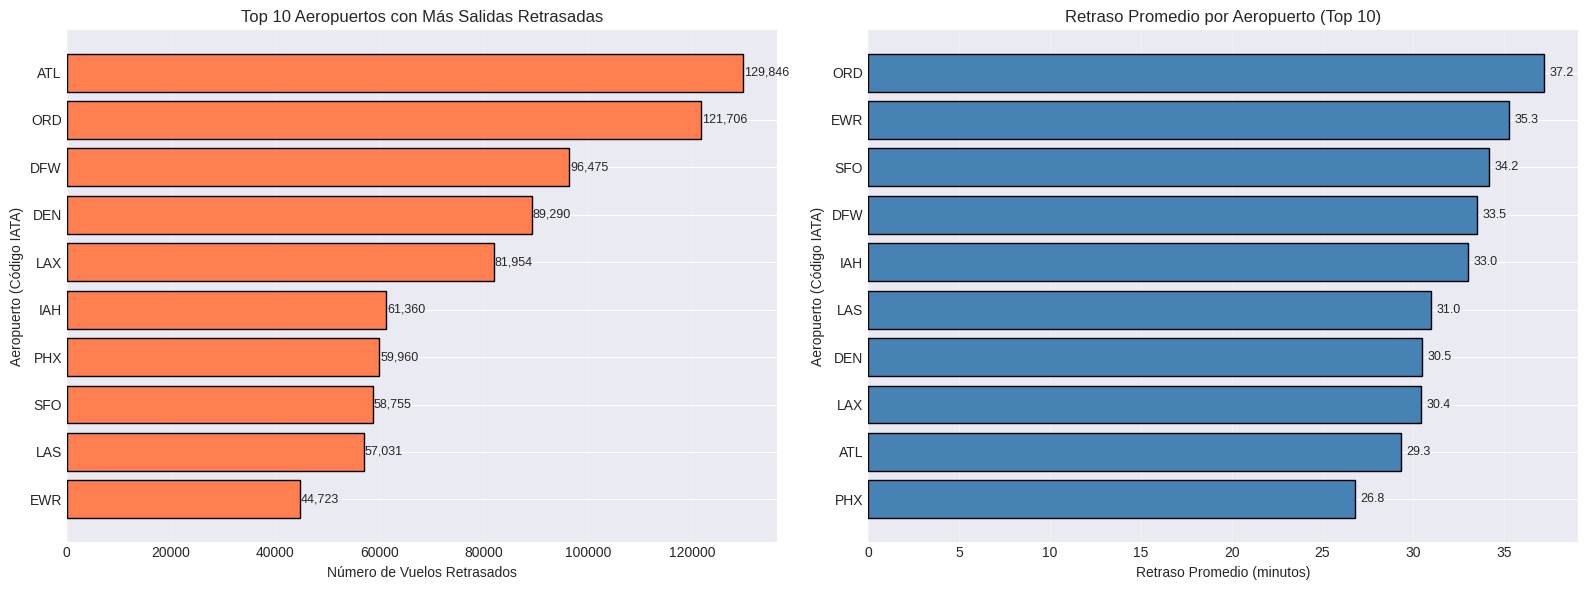


✓ El aeropuerto con más salidas retrasadas es: ATL
  Total de vuelos retrasados: 129,846
  Retraso promedio: 29.33 minutos


In [17]:
# Análisis de aeropuertos con más retrasos
airport_col = 'ORIGIN_AIRPORT'

# 1. Aeropuertos con mayor número de salidas con retraso
airports_delays = (df_analysis
    .filter(df_analysis[delay_col] > 0)  # Solo vuelos con retraso
    .group_by(airport_col)
    .aggregate([
        _.count().name('vuelos_retrasados'),
        _[delay_col].mean().name('retraso_promedio'),
        _[delay_col].std().name('desv_std')
    ])
    .order_by(ibis.desc('vuelos_retrasados'))
    .limit(10)
    .execute()
)

# Crear tabla para visualización con formato
display_table = airports_delays.copy()
display_table.columns = ['Aeropuerto', 'Vuelos Retrasados', 'Retraso Promedio (min)', 'Desv. Std.']

print("=== TOP 10 AEROPUERTOS CON MÁS SALIDAS RETRASADAS ===\n")
display(display_table.style.format({
    'Vuelos Retrasados': '{:,.0f}',
    'Retraso Promedio (min)': '{:.2f}',
    'Desv. Std.': '{:.2f}'
}).background_gradient(subset=['Vuelos Retrasados'], cmap='Reds'))

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfica de barras: Número de vuelos retrasados (invertir para mayor arriba)
airports = airports_delays[airport_col].tolist()[::-1]
delayed_counts = airports_delays['vuelos_retrasados'].tolist()[::-1]

bars1 = axes[0].barh(airports, delayed_counts, color='coral', edgecolor='black')
axes[0].set_xlabel('Número de Vuelos Retrasados')
axes[0].set_ylabel('Aeropuerto (Código IATA)')
axes[0].set_title('Top 10 Aeropuertos con Más Salidas Retrasadas')
axes[0].grid(axis='x', alpha=0.3)

# Añadir valores en las barras
for bar, val in zip(bars1, delayed_counts):
    axes[0].text(val + 200, bar.get_y() + bar.get_height()/2, 
                f'{val:,.0f}', va='center', fontsize=9)

# Gráfica de barras: Retraso promedio (ordenar por retraso promedio de mayor a menor)
airports_sorted_by_delay = airports_delays.sort_values('retraso_promedio', ascending=False)
airports_delay = airports_sorted_by_delay[airport_col].tolist()[::-1]
avg_delays_sorted = airports_sorted_by_delay['retraso_promedio'].tolist()[::-1]

bars2 = axes[1].barh(airports_delay, avg_delays_sorted, color='steelblue', edgecolor='black')
axes[1].set_xlabel('Retraso Promedio (minutos)')
axes[1].set_ylabel('Aeropuerto (Código IATA)')
axes[1].set_title('Retraso Promedio por Aeropuerto (Top 10)')
axes[1].grid(axis='x', alpha=0.3)

# Añadir valores en las barras
for bar, val in zip(bars2, avg_delays_sorted):
    axes[1].text(val + 0.3, bar.get_y() + bar.get_height()/2, 
                f'{val:.1f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\n✓ El aeropuerto con más salidas retrasadas es: {airports_delays.iloc[0][airport_col]}")
print(f"  Total de vuelos retrasados: {airports_delays.iloc[0]['vuelos_retrasados']:,}")
print(f"  Retraso promedio: {airports_delays.iloc[0]['retraso_promedio']:.2f} minutos")


=== MOTIVOS DE CANCELACIÓN MÁS FRECUENTES (GLOBAL) ===



Motivo,Frecuencia,Porcentaje,Porcentaje_str
Weather,"48,851",54.350000,54.35%
Airline/Carrier,"25,262",28.110000,28.11%
National Air System,"15,749",17.520000,17.52%
Security,22,0.020000,0.02%



=== MOTIVOS DE CANCELACIÓN POR AEROPUERTO (TOP 5) ===



Aeropuerto,Total_Cancelaciones,Motivo,Frecuencia,Porcentaje
ATL,"2,557",Weather,"1,707",66.8%
ATL,"2,557",Airline/Carrier,695,27.2%
ATL,"2,557",National Air System,155,6.1%
ORD,"8,548",Weather,"4,769",55.8%
ORD,"8,548",National Air System,"2,334",27.3%
ORD,"8,548",Airline/Carrier,"1,445",16.9%
DFW,"6,254",Weather,"4,664",74.6%
DFW,"6,254",Airline/Carrier,"1,455",23.3%
DFW,"6,254",National Air System,135,2.2%
DEN,"2,123",Weather,"1,383",65.1%


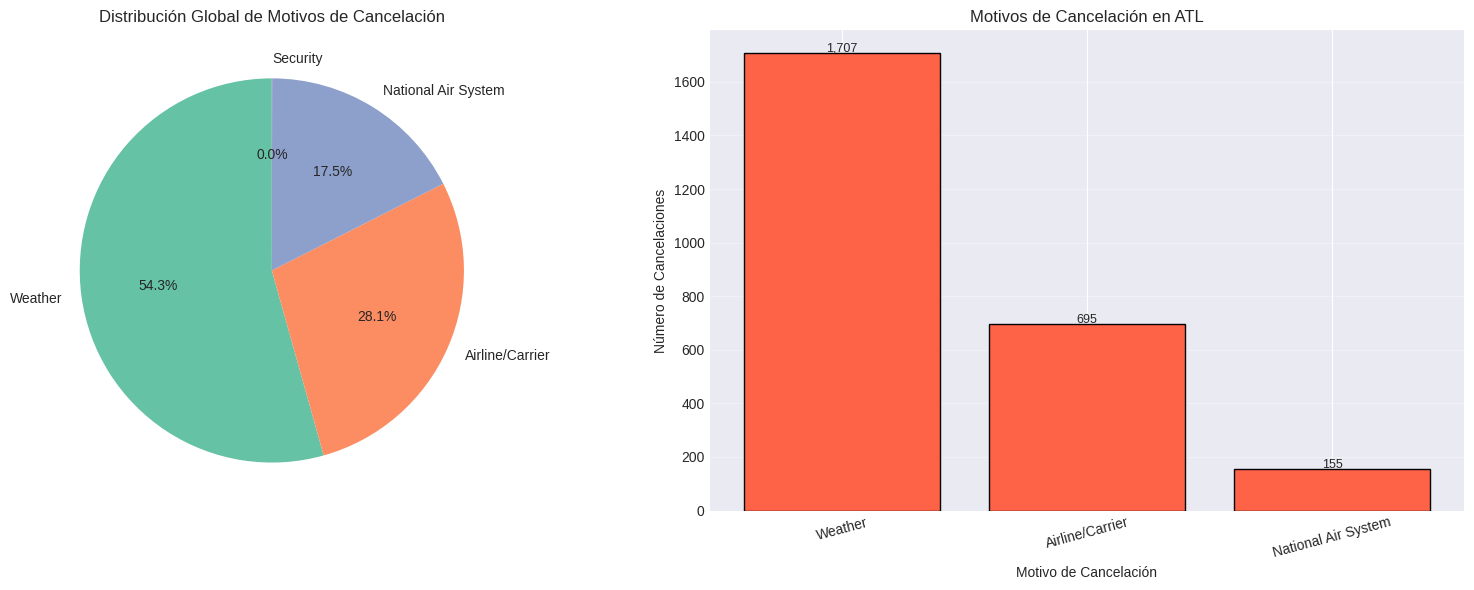


✓ Motivo de cancelación más frecuente globalmente: Weather
  Frecuencia: 48,851 cancelaciones (54.35%)


In [18]:
# 2. Análisis de motivos de cancelación
cancellation_reason_col = 'CANCELLATION_REASON'
cancellation_desc_col = 'CANCELLATION_DESCRIPTION'
cancel_col = 'CANCELLED'
airport_col = 'ORIGIN_AIRPORT'

# Obtener datos de cancelaciones con motivo
df_cancellations = df_analysis.select([
    airport_col, 
    cancel_col, 
    cancellation_reason_col,
    cancellation_desc_col
]).execute()

# Filtrar solo vuelos cancelados con motivo especificado
df_cancelled = df_cancellations[
    (df_cancellations[cancel_col] == 1) & 
    (df_cancellations[cancellation_reason_col].notna())
]

# Motivos de cancelación globales (usar descripción en lugar de código)
cancellation_reasons_global = df_cancelled[cancellation_desc_col].value_counts()

print("\n=== MOTIVOS DE CANCELACIÓN MÁS FRECUENTES (GLOBAL) ===\n")
total_cancelled = len(df_cancelled)

# Crear DataFrame para mejor visualización
df_reasons_global = pd.DataFrame({
    'Motivo': cancellation_reasons_global.index,
    'Frecuencia': cancellation_reasons_global.values,
    'Porcentaje': (cancellation_reasons_global.values / total_cancelled * 100).round(2)
})
df_reasons_global['Porcentaje_str'] = df_reasons_global['Porcentaje'].apply(lambda x: f"{x:.2f}%")

display(df_reasons_global.style
        .format({'Frecuencia': '{:,.0f}'})
        .hide(axis='index')
        .set_properties(**{'text-align': 'left'})
        .set_table_styles([
            {'selector': 'th', 'props': [('text-align', 'left'), ('font-weight', 'bold')]}
        ])
)

# Motivos de cancelación por aeropuerto (Top 5 aeropuertos)
print("\n=== MOTIVOS DE CANCELACIÓN POR AEROPUERTO (TOP 5) ===\n")

top5_airports = airports_delays[airport_col].head(5).tolist()

# Crear lista para almacenar datos de cada aeropuerto
airport_cancellation_data = []

for airport in top5_airports:
    df_airport_cancelled = df_cancelled[df_cancelled[airport_col] == airport]
    if len(df_airport_cancelled) > 0:
        reasons = df_airport_cancelled[cancellation_desc_col].value_counts()
        total_airport_cancelled = len(df_airport_cancelled)
        
        # Agregar top 3 motivos para este aeropuerto
        for i, (reason, count) in enumerate(reasons.head(3).items()):
            pct = (count / total_airport_cancelled) * 100
            airport_cancellation_data.append({
                'Aeropuerto': airport,
                'Total_Cancelaciones': total_airport_cancelled,
                'Motivo': reason,
                'Frecuencia': count,
                'Porcentaje': pct
            })

# Crear DataFrame con todos los datos
df_airport_reasons = pd.DataFrame(airport_cancellation_data)
df_airport_reasons['Porcentaje_str'] = df_airport_reasons['Porcentaje'].apply(lambda x: f"{x:.1f}%")

# Mostrar tabla formateada
display(df_airport_reasons[['Aeropuerto', 'Total_Cancelaciones', 'Motivo', 'Frecuencia', 'Porcentaje_str']]
        .rename(columns={'Porcentaje_str': 'Porcentaje'})
        .style
        .format({'Frecuencia': '{:,.0f}', 'Total_Cancelaciones': '{:,.0f}'})
        .hide(axis='index')
        .set_properties(**{'text-align': 'left'})
        .set_table_styles([
            {'selector': 'th', 'props': [('text-align', 'left'), ('font-weight', 'bold')]}
        ])
)

# Visualización de motivos de cancelación
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico de pastel: Distribución global
axes[0].pie(cancellation_reasons_global.values, 
           labels=cancellation_reasons_global.index,
           autopct='%1.1f%%',
           startangle=90,
           colors=sns.color_palette("Set2"))
axes[0].set_title('Distribución Global de Motivos de Cancelación')

# Gráfico de barras: Motivos por aeropuerto (aeropuerto con más retrasos)
top_airport = airports_delays.iloc[0][airport_col]
df_top_airport_cancelled = df_cancelled[df_cancelled[airport_col] == top_airport]
if len(df_top_airport_cancelled) > 0:
    reasons_top = df_top_airport_cancelled[cancellation_desc_col].value_counts()
    axes[1].bar(reasons_top.index, reasons_top.values, color='tomato', edgecolor='black')
    axes[1].set_xlabel('Motivo de Cancelación')
    axes[1].set_ylabel('Número de Cancelaciones')
    axes[1].set_title(f'Motivos de Cancelación en {top_airport}')
    axes[1].grid(axis='y', alpha=0.3)
    axes[1].tick_params(axis='x', rotation=15)
    
    # Añadir valores sobre las barras
    for i, (reason, count) in enumerate(zip(reasons_top.index, reasons_top.values)):
        axes[1].text(i, count + 5, f'{count:,}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\n✓ Motivo de cancelación más frecuente globalmente: {cancellation_reasons_global.index[0]}")
print(f"  Frecuencia: {cancellation_reasons_global.iloc[0]:,} cancelaciones ({cancellation_reasons_global.iloc[0]/total_cancelled*100:.2f}%)")

### 3.6 Análisis de Retrasos por Día de la Semana

Analizamos qué días de la semana tienen mayor probabilidad de retrasos en las salidas.

=== ANÁLISIS DE RETRASOS POR DÍA DE LA SEMANA ===



,Día de la Semana,N° Vuelos,Retraso Promedio (min),Mediana (min),% con Retraso,Desv. Std.
0,Lunes,"845,288",10.87,-1.00,38.30%,40.34
1,Martes,"829,991",9.16,-2.00,35.64%,36.94
2,Miércoles,"845,583",8.65,-2.00,35.84%,35.35
3,Jueves,"860,780",9.96,-1.00,38.85%,37.15
4,Viernes,"853,884",9.43,-1.00,38.51%,35.71
5,Sábado,"692,253",7.83,-2.00,34.41%,36.16
6,Domingo,"805,147",9.40,-2.00,37.46%,37.49


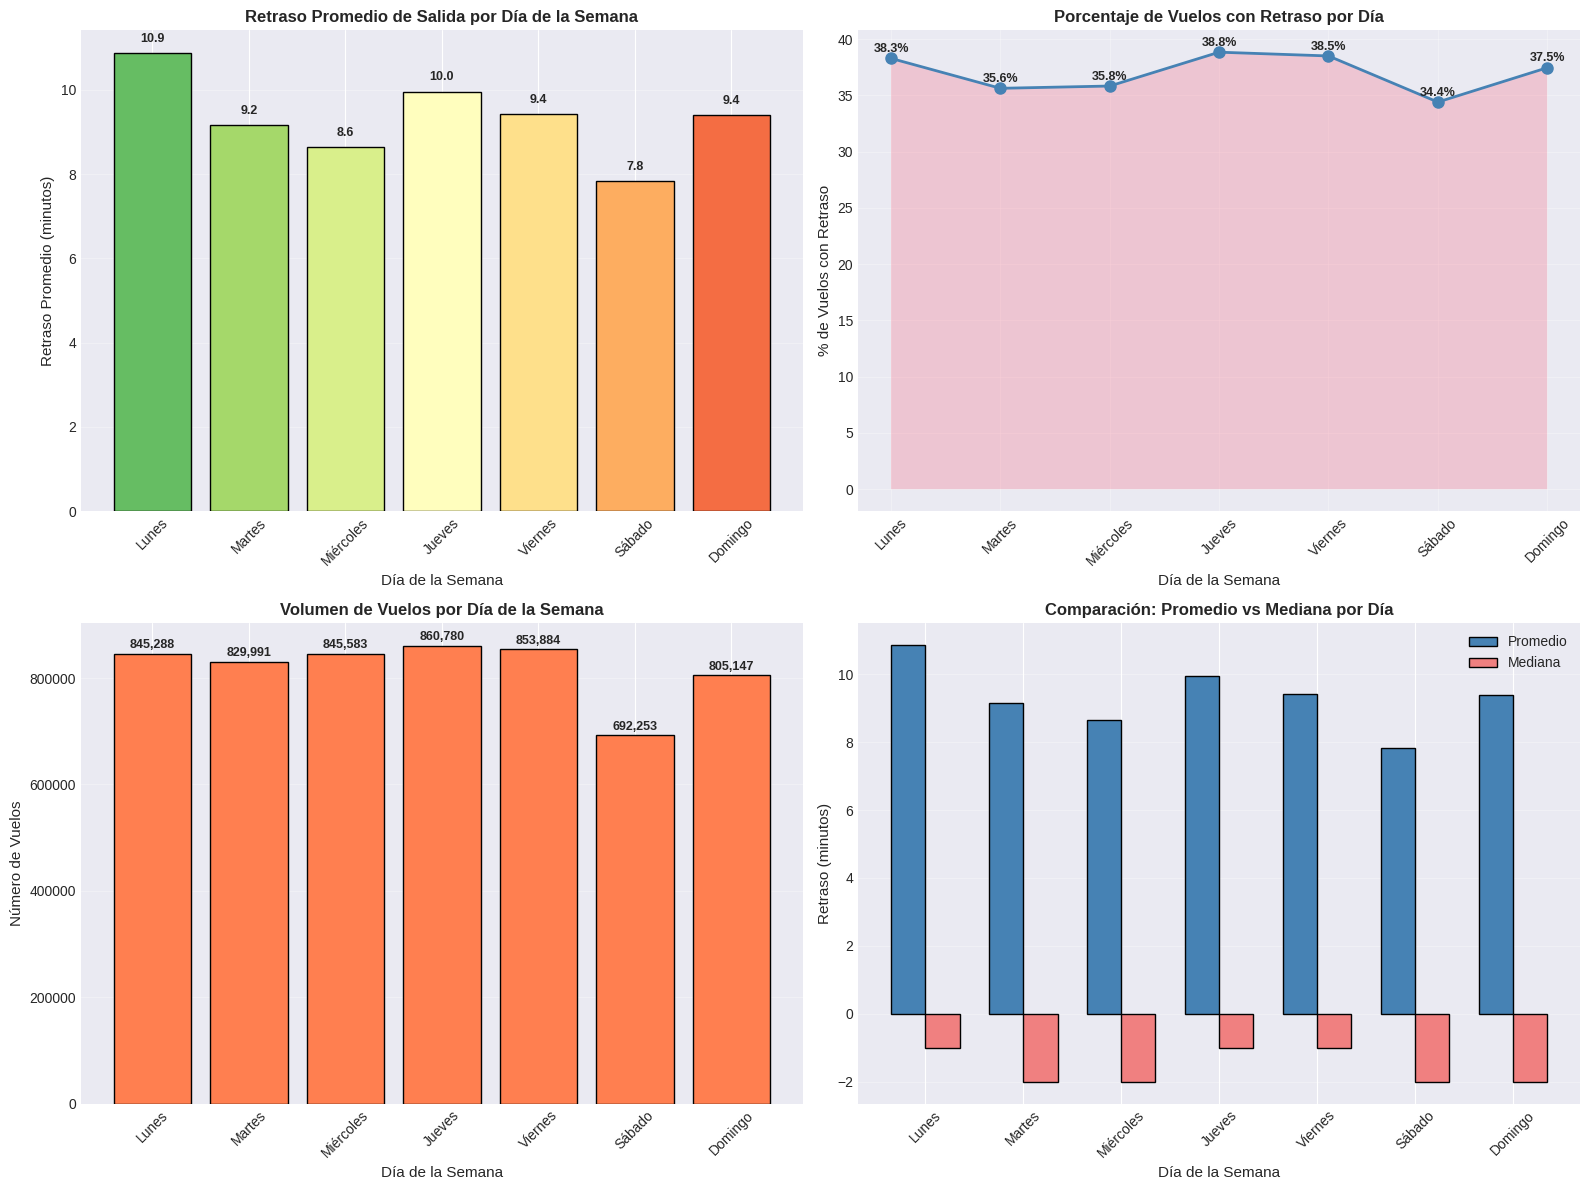


Resumen del Análisis por Día de la Semana:
• Día con MAYOR retraso promedio: Lunes (10.87 min)
• Día con MENOR retraso promedio: Sábado (7.83 min)
• Día con MAYOR probabilidad de retraso: Jueves (38.85% de vuelos)
• Diferencia entre mejor y peor día: 3.04 minutos


In [19]:
# Análisis de retrasos por día de la semana
# Primero necesitamos obtener el día de la semana de cada vuelo

# Obtener datos con fecha completa
df_day_analysis = (df_analysis
    .select(['YEAR', 'MONTH', 'DAY', delay_col])
    .execute()
    .dropna()
)

# Crear fecha y extraer día de la semana
df_day_analysis['fecha'] = pd.to_datetime(
    df_day_analysis[['YEAR', 'MONTH', 'DAY']].rename(columns={'YEAR': 'year', 'MONTH': 'month', 'DAY': 'day'})
)
df_day_analysis['dia_semana'] = df_day_analysis['fecha'].dt.day_name()
df_day_analysis['dia_semana_num'] = df_day_analysis['fecha'].dt.dayofweek

# Mapear nombres de días en español
dias_espanol = {
    'Monday': 'Lunes',
    'Tuesday': 'Martes',
    'Wednesday': 'Miércoles',
    'Thursday': 'Jueves',
    'Friday': 'Viernes',
    'Saturday': 'Sábado',
    'Sunday': 'Domingo'
}
df_day_analysis['dia_semana_esp'] = df_day_analysis['dia_semana'].map(dias_espanol)

# Ordenar por número de día (lunes=0, domingo=6)
orden_dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']

# Estadísticas por día de la semana
stats_by_day = df_day_analysis.groupby('dia_semana_esp')[delay_col].agg([
    ('n_vuelos', 'count'),
    ('retraso_promedio', 'mean'),
    ('retraso_mediana', 'median'),
    ('desv_std', 'std'),
    ('vuelos_con_retraso', lambda x: (x > 0).sum())
]).reset_index()

# Calcular porcentaje de vuelos con retraso
stats_by_day['pct_con_retraso'] = (stats_by_day['vuelos_con_retraso'] / stats_by_day['n_vuelos']) * 100

# Ordenar por día de la semana
stats_by_day['orden'] = stats_by_day['dia_semana_esp'].map({dia: i for i, dia in enumerate(orden_dias)})
stats_by_day = stats_by_day.sort_values('orden').reset_index(drop=True)

# Mostrar tabla
display_table_day = stats_by_day[['dia_semana_esp', 'n_vuelos', 'retraso_promedio', 'retraso_mediana', 'pct_con_retraso', 'desv_std']].copy()
display_table_day.columns = ['Día de la Semana', 'N° Vuelos', 'Retraso Promedio (min)', 'Mediana (min)', '% con Retraso', 'Desv. Std.']

print("=== ANÁLISIS DE RETRASOS POR DÍA DE LA SEMANA ===\n")
display(display_table_day.style.format({
    'N° Vuelos': '{:,.0f}',
    'Retraso Promedio (min)': '{:.2f}',
    'Mediana (min)': '{:.2f}',
    '% con Retraso': '{:.2f}%',
    'Desv. Std.': '{:.2f}'
}).background_gradient(subset=['Retraso Promedio (min)'], cmap='YlOrRd'))

# Visualización
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Gráfico de barras: Retraso promedio por día
ax1 = axes[0, 0]
colors_days = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(stats_by_day)))
bars1 = ax1.bar(stats_by_day['dia_semana_esp'], stats_by_day['retraso_promedio'], 
                color=colors_days, edgecolor='black')
ax1.set_xlabel('Día de la Semana', fontsize=11)
ax1.set_ylabel('Retraso Promedio (minutos)', fontsize=11)
ax1.set_title('Retraso Promedio de Salida por Día de la Semana', fontsize=12, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)
for bar, val in zip(bars1, stats_by_day['retraso_promedio']):
    ax1.text(bar.get_x() + bar.get_width()/2, val + 0.2, f'{val:.1f}', 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

# 2. Gráfico de líneas: Porcentaje de vuelos con retraso
ax2 = axes[0, 1]
ax2.plot(stats_by_day['dia_semana_esp'], stats_by_day['pct_con_retraso'], 
         marker='o', linewidth=2, markersize=8, color='steelblue')
ax2.fill_between(range(len(stats_by_day)), stats_by_day['pct_con_retraso'], alpha=0.3)
ax2.set_xlabel('Día de la Semana', fontsize=11)
ax2.set_ylabel('% de Vuelos con Retraso', fontsize=11)
ax2.set_title('Porcentaje de Vuelos con Retraso por Día', fontsize=12, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(alpha=0.3)
for i, (dia, pct) in enumerate(zip(stats_by_day['dia_semana_esp'], stats_by_day['pct_con_retraso'])):
    ax2.text(i, pct + 0.3, f'{pct:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

# 3. Gráfico de barras: Volumen de vuelos por día
ax3 = axes[1, 0]
bars3 = ax3.bar(stats_by_day['dia_semana_esp'], stats_by_day['n_vuelos'], 
                color='coral', edgecolor='black')
ax3.set_xlabel('Día de la Semana', fontsize=11)
ax3.set_ylabel('Número de Vuelos', fontsize=11)
ax3.set_title('Volumen de Vuelos por Día de la Semana', fontsize=12, fontweight='bold')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(axis='y', alpha=0.3)
for bar, val in zip(bars3, stats_by_day['n_vuelos']):
    ax3.text(bar.get_x() + bar.get_width()/2, val + 5000, f'{val:,.0f}', 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

# 4. Gráfico combinado: Comparación mediana vs promedio
ax4 = axes[1, 1]
x = np.arange(len(stats_by_day))
width = 0.35
bars4a = ax4.bar(x - width/2, stats_by_day['retraso_promedio'], width, 
                 label='Promedio', color='steelblue', edgecolor='black')
bars4b = ax4.bar(x + width/2, stats_by_day['retraso_mediana'], width,
                 label='Mediana', color='lightcoral', edgecolor='black')
ax4.set_xlabel('Día de la Semana', fontsize=11)
ax4.set_ylabel('Retraso (minutos)', fontsize=11)
ax4.set_title('Comparación: Promedio vs Mediana por Día', fontsize=12, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(stats_by_day['dia_semana_esp'], rotation=45)
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Resumen
dia_mayor_retraso = stats_by_day.loc[stats_by_day['retraso_promedio'].idxmax()]
dia_menor_retraso = stats_by_day.loc[stats_by_day['retraso_promedio'].idxmin()]
dia_mayor_prob = stats_by_day.loc[stats_by_day['pct_con_retraso'].idxmax()]

print(f"\nResumen del Análisis por Día de la Semana:")
print(f"• Día con MAYOR retraso promedio: {dia_mayor_retraso['dia_semana_esp']} ({dia_mayor_retraso['retraso_promedio']:.2f} min)")
print(f"• Día con MENOR retraso promedio: {dia_menor_retraso['dia_semana_esp']} ({dia_menor_retraso['retraso_promedio']:.2f} min)")
print(f"• Día con MAYOR probabilidad de retraso: {dia_mayor_prob['dia_semana_esp']} ({dia_mayor_prob['pct_con_retraso']:.2f}% de vuelos)")
print(f"• Diferencia entre mejor y peor día: {dia_mayor_retraso['retraso_promedio'] - dia_menor_retraso['retraso_promedio']:.2f} minutos")

### 3.7 Tablas de Contingencia

Creamos una tabla de contingencia para analizar la relación entre aerolíneas y categorías de retraso.

=== TABLA DE CONTINGENCIA: AEROLÍNEA × CATEGORÍA DE RETRASO ===



categoria_retraso,Desconocido,Puntual/Adelantado,Retraso Leve (1-15 min),Retraso Moderado (16-60 min),Retraso Severo (>60 min),Total
AIRLINE,,,,,,
B6,4205,160782,46282,36436,19343,267048
F9,546,55397,14739,12691,7463,90836
NK,1925,63365,21448,19123,11518,117379
UA,6189,252984,140397,76228,39925,515723
WN,15726,679322,312669,188617,65521,1261855
Total,28591,1211850,535535,333095,143770,2252841


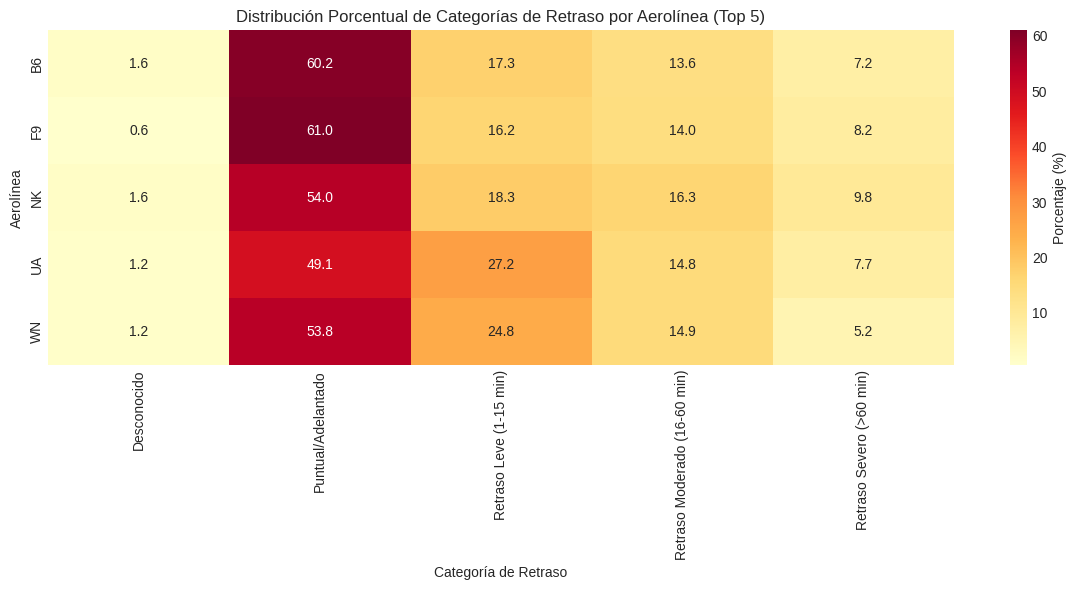

In [20]:
# Crear categorías de retraso
airline_col = 'AIRLINE'
delay_col = 'DEPARTURE_DELAY'

def categorize_delay(delay):
    if pd.isna(delay):
        return 'Desconocido'
    elif delay <= 0:
        return 'Puntual/Adelantado'
    elif delay <= 15:
        return 'Retraso Leve (1-15 min)'
    elif delay <= 60:
        return 'Retraso Moderado (16-60 min)'
    else:
        return 'Retraso Severo (>60 min)'

# Obtener datos completos para análisis de contingencia (necesitamos columnas múltiples)
df_sample = df_analysis.select([airline_col, delay_col]).execute()
df_sample['categoria_retraso'] = df_sample[delay_col].apply(categorize_delay)

# Tabla de contingencia (Top 5 aerolíneas)
top5_airlines = stats_by_airline[airline_col].head(5).tolist()
df_top5 = df_sample[df_sample[airline_col].isin(top5_airlines)]

contingency_table = pd.crosstab(
    df_top5[airline_col], 
    df_top5['categoria_retraso'],
    margins=True,
    margins_name='Total'
)

print("=== TABLA DE CONTINGENCIA: AEROLÍNEA × CATEGORÍA DE RETRASO ===\n")
display(contingency_table)

# Visualización con heatmap
fig, ax = plt.subplots(figsize=(12, 6))
ct_pct = pd.crosstab(df_top5[airline_col], df_top5['categoria_retraso'], normalize='index') * 100
sns.heatmap(ct_pct, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax, cbar_kws={'label': 'Porcentaje (%)'})
ax.set_title('Distribución Porcentual de Categorías de Retraso por Aerolínea (Top 5)')
ax.set_xlabel('Categoría de Retraso')
ax.set_ylabel('Aerolínea')
plt.tight_layout()
plt.show()

La tabla muestra que **Frontier (F9)** lidera en puntualidad con 61.0% de vuelos puntuales/adelantados, seguida por JetBlue (B6) con 60.2%. Southwest (WN), a pesar de tener el mayor volumen, muestra solo 53.8% de puntualidad. **Spirit (NK)** tiene la mayor proporción de retrasos severos (9.8%), seguida por Frontier (8.2%). El heatmap revela que United (UA) destaca con 27.2% de retrasos leves, el porcentaje más alto entre las 5 aerolíneas. Los retrasos moderados oscilan entre 13.6-16.3% para todas las aerolíneas.

### 3.7 Correlación y Covarianza

Analizamos la relación entre retraso de salida y retraso de llegada.

=== CORRELACIÓN Y COVARIANZA ===

Correlación de Pearson: 0.9447
Covarianza: 1368.55

Interpretación de correlación:
  → Correlación fuerte (positiva)


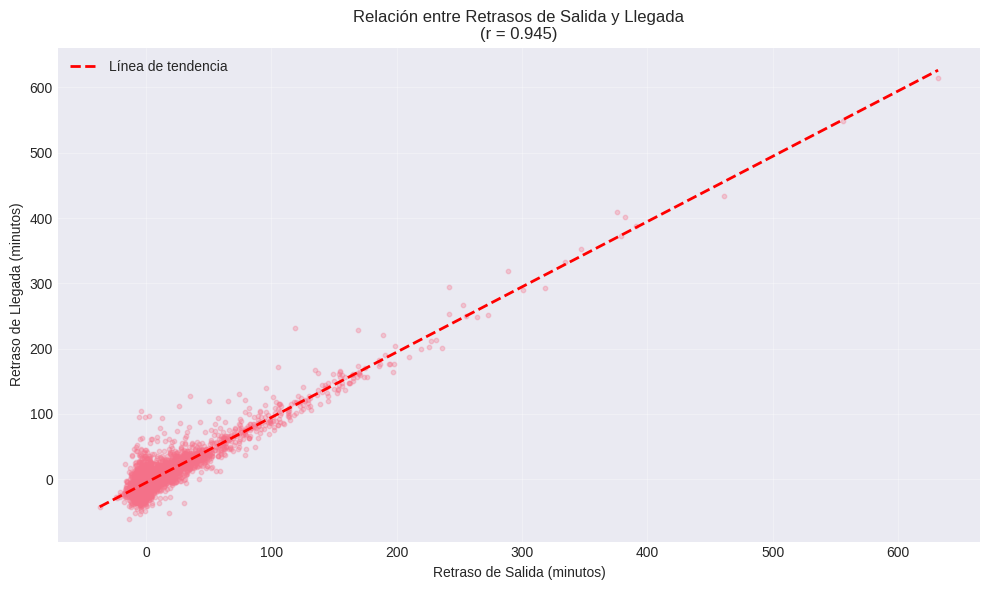

In [21]:
# Correlación entre retrasos de salida y llegada
arr_delay_col = 'ARRIVAL_DELAY'

# Obtener todos los datos con las columnas necesarias
df_corr = df_analysis.select([delay_col, arr_delay_col]).execute().dropna()

# Calcular correlación y covarianza
correlation = df_corr[delay_col].corr(df_corr[arr_delay_col])
covariance = df_corr[delay_col].cov(df_corr[arr_delay_col])

print(f"=== CORRELACIÓN Y COVARIANZA ===\n")
print(f"Correlación de Pearson: {correlation:.4f}")
print(f"Covarianza: {covariance:.2f}")
print(f"\nInterpretación de correlación:")
if abs(correlation) > 0.7:
    print(f"  → Correlación fuerte ({'positiva' if correlation > 0 else 'negativa'})")
elif abs(correlation) > 0.3:
    print(f"  → Correlación moderada ({'positiva' if correlation > 0 else 'negativa'})")
else:
    print(f"  → Correlación débil")

# Scatter plot
fig, ax = plt.subplots(figsize=(10, 6))
# Tomar muestra aleatoria para visualización
sample_plot = df_corr.sample(min(5000, len(df_corr)))
ax.scatter(sample_plot[delay_col], sample_plot[arr_delay_col], alpha=0.3, s=10)
ax.set_xlabel('Retraso de Salida (minutos)')
ax.set_ylabel('Retraso de Llegada (minutos)')
ax.set_title(f'Relación entre Retrasos de Salida y Llegada\n(r = {correlation:.3f})')
ax.grid(alpha=0.3)

# Línea de tendencia
z = np.polyfit(sample_plot[delay_col], sample_plot[arr_delay_col], 1)
p = np.poly1d(z)
x_line = np.linspace(sample_plot[delay_col].min(), sample_plot[delay_col].max(), 100)
ax.plot(x_line, p(x_line), "r--", linewidth=2, label='Línea de tendencia')
ax.legend()

plt.tight_layout()
plt.show()

El análisis revela una **correlación de Pearson de 0.9447**, extremadamente alta, indicando que los retrasos de salida y llegada están casi perfectamente sincronizados. La covarianza de 1,368.55 confirma que ambas variables varían conjuntamente de manera significativa. El scatter plot muestra una relación lineal clara: los puntos se agrupan fuertemente alrededor de la línea de tendencia roja. **Implicación práctica**: un retraso en la salida se traduce casi directamente en retraso de llegada, sugiriendo poca capacidad de recuperación de tiempo durante el vuelo.

## 4. Análisis de Probabilidad

### 4.1 Probabilidades Básicas

Calculamos probabilidades fundamentales relacionadas con retrasos y cancelaciones.

In [22]:
# Probabilidades básicas - obtener todos los datos
cancel_col = 'CANCELLED'
df_prob = df_analysis.select([delay_col, cancel_col]).execute()

# Datos de retraso (solo vuelos con datos de retraso)
delay_data_prob = df_prob[delay_col].dropna()
total_flights = len(delay_data_prob)

# P(Retraso) - vuelos con retraso > 0
delayed_flights = (delay_data_prob > 0).sum()
p_delay = delayed_flights / total_flights

# P(Puntual) - vuelos con retraso <= 0
ontime_flights = (delay_data_prob <= 0).sum()
p_ontime = ontime_flights / total_flights

# P(Cancelación)
total_all_flights = len(df_prob)
cancelled_flights = df_prob[cancel_col].sum() if df_prob[cancel_col].dtype == bool else (df_prob[cancel_col] == 1).sum()
p_cancelled = cancelled_flights / total_all_flights

print("=== PROBABILIDADES BÁSICAS ===\n")
print(f"Total de vuelos con datos: {total_flights:,}\n")
print(f"P(Retraso de salida > 0 min):  {p_delay:.4f} ({p_delay*100:.2f}%)")
print(f"P(Vuelo puntual/adelantado):   {p_ontime:.4f} ({p_ontime*100:.2f}%)")
print(f"P(Cancelación):                {p_cancelled:.4f} ({p_cancelled*100:.2f}%)")

# Validar regla de adición (deben sumar 1 para eventos mutuamente excluyentes)
suma_prob = p_delay + p_ontime
print(f"\nVerificación: P(Retraso) + P(Puntual) = {suma_prob:.4f}")
print(f"  → Suma = 1.0 ✓ (eventos mutuamente excluyentes y exhaustivos)")

=== PROBABILIDADES BÁSICAS ===

Total de vuelos con datos: 5,732,926

P(Retraso de salida > 0 min):  0.3708 (37.08%)
P(Vuelo puntual/adelantado):   0.6292 (62.92%)
P(Cancelación):                0.0154 (1.54%)

Verificación: P(Retraso) + P(Puntual) = 1.0000
  → Suma = 1.0 ✓ (eventos mutuamente excluyentes y exhaustivos)


De los 5.7 millones de vuelos analizados, **37.08% tienen retraso de salida** mientras que **62.92% salen puntuales o adelantados**. Solo **1.54% se cancelan**. La verificación confirma que las probabilidades suman 1.0, validando que los eventos son mutuamente excluyentes. **Conclusión práctica**: casi 2 de cada 3 vuelos operan a tiempo, pero más de un tercio experimenta retrasos.

### 4.2 Probabilidad Condicional y Teorema de Bayes

Calculamos probabilidades condicionales: probabilidad de retraso de llegada dado que hubo retraso de salida.

In [23]:
# Probabilidad condicional
# P(Retraso llegada | Retraso salida)

# Obtener todos los datos para análisis condicional
df_cond = df_analysis.select([delay_col, arr_delay_col]).execute().dropna()

# Eventos
dep_delayed = df_cond[delay_col] > 0
arr_delayed = df_cond[arr_delay_col] > 0

# P(A ∩ B) - ambos retrasos
both_delayed = (dep_delayed & arr_delayed).sum()
p_both = both_delayed / len(df_cond)

# P(Retraso llegada | Retraso salida)
p_arr_given_dep = both_delayed / dep_delayed.sum()

# P(Retraso salida | Retraso llegada) - Teorema de Bayes
p_dep_given_arr = both_delayed / arr_delayed.sum()

print("=== PROBABILIDAD CONDICIONAL ===\n")
print(f"P(Retraso llegada ∩ Retraso salida): {p_both:.4f}")
print(f"\nP(Retraso llegada | Retraso salida): {p_arr_given_dep:.4f}")
print(f"  → Si un vuelo sale con retraso, hay {p_arr_given_dep*100:.1f}% probabilidad de que llegue con retraso")
print(f"\nP(Retraso salida | Retraso llegada): {p_dep_given_arr:.4f}")
print(f"  → Si un vuelo llega con retraso, hay {p_dep_given_arr*100:.1f}% probabilidad de que haya salido con retraso")

# Verificar independencia
p_dep = dep_delayed.sum() / len(df_cond)
p_arr = arr_delayed.sum() / len(df_cond)
p_expected_if_independent = p_dep * p_arr

print(f"\nPrueba de independencia:")
print(f"  P(A) × P(B) = {p_expected_if_independent:.4f}")
print(f"  P(A ∩ B) = {p_both:.4f}")
if abs(p_both - p_expected_if_independent) < 0.01:
    print("  → Los eventos son aproximadamente independientes")
else:
    print("  → Los eventos son dependientes (correlacionados)")

=== PROBABILIDAD CONDICIONAL ===

P(Retraso llegada ∩ Retraso salida): 0.2639

P(Retraso llegada | Retraso salida): 0.7131
  → Si un vuelo sale con retraso, hay 71.3% probabilidad de que llegue con retraso

P(Retraso salida | Retraso llegada): 0.7227
  → Si un vuelo llega con retraso, hay 72.3% probabilidad de que haya salido con retraso

Prueba de independencia:
  P(A) × P(B) = 0.1352
  P(A ∩ B) = 0.2639
  → Los eventos son dependientes (correlacionados)


Los resultados confirman **fuerte dependencia** entre retrasos: si un vuelo sale retrasado, hay **71.3% de probabilidad** de que llegue retrasado. La prueba de independencia muestra que P(A∩B)=0.2639 es muy superior a P(A)×P(B)=0.1352, casi el doble, rechazando completamente la hipótesis de independencia. **Conclusión práctica**: Los retrasos de salida predicen fuertemente los retrasos de llegada, validando la correlación de 0.9447 observada anteriormente.

### 4.3 Valor Esperado y Error Estándar

Calculamos el valor esperado (media poblacional) y el error estándar de la media.

In [24]:
# Valor esperado y error estándar
n = len(delay_data)
expected_value = delay_data.mean()  # E(X)
variance = delay_data.var()  # Var(X)
std_dev = delay_data.std()  # σ
standard_error = std_dev / np.sqrt(n)  # SE = σ/√n

print("=== VALOR ESPERADO Y ERROR ESTÁNDAR ===\n")
print(f"Tamaño del dataset (n):      {n:,}")
print(f"Valor Esperado E(X):         {expected_value:.2f} minutos")
print(f"Varianza Var(X):             {variance:.2f}")
print(f"Desviación Estándar σ:       {std_dev:.2f}")
print(f"Error Estándar SE = σ/√n:    {standard_error:.4f}")
print(f"\nInterpretación:")
print(f"  - El retraso promedio esperado es {expected_value:.2f} minutos")
print(f"  - El error estándar de {standard_error:.4f} indica la precisión excepcional de nuestra estimación")
print(f"  - Con {n:,} observaciones (dataset completo), la estimación es prácticamente exacta")

=== VALOR ESPERADO Y ERROR ESTÁNDAR ===

Tamaño del dataset (n):      5,732,926
Valor Esperado E(X):         9.37 minutos
Varianza Var(X):             1375.00
Desviación Estándar σ:       37.08
Error Estándar SE = σ/√n:    0.0155

Interpretación:
  - El retraso promedio esperado es 9.37 minutos
  - El error estándar de 0.0155 indica la precisión excepcional de nuestra estimación
  - Con 5,732,926 observaciones (dataset completo), la estimación es prácticamente exacta


Con 5.7 millones de observaciones, el **error estándar es de solo 0.0155 minutos** (menos de 1 segundo), lo que significa que nuestra estimación del retraso promedio de **9.37 minutos es extremadamente precisa**. La varianza de 1,375 y desviación estándar de 37.08 reflejan la alta dispersión de los retrasos individuales, pero el enorme tamaño muestral hace que el promedio estimado sea prácticamente igual al poblacional. **Conclusión**: Podemos afirmar con certeza casi absoluta que el retraso promedio real está en 9.37 ± 0.02 minutos.

## 5. Distribuciones de Probabilidad

### 5.1 Ajuste a Distribución Normal

Evaluamos si los retrasos siguen una distribución normal.

=== PRUEBA DE NORMALIDAD (Shapiro-Wilk) ===

Estadístico W: 0.3078
P-valor: 2.4373e-87

Hipótesis:
  H₀: Los datos siguen una distribución normal
  H₁: Los datos NO siguen una distribución normal

Conclusión (α = 0.05):
  → Rechazamos H₀ (los datos NO son normales)


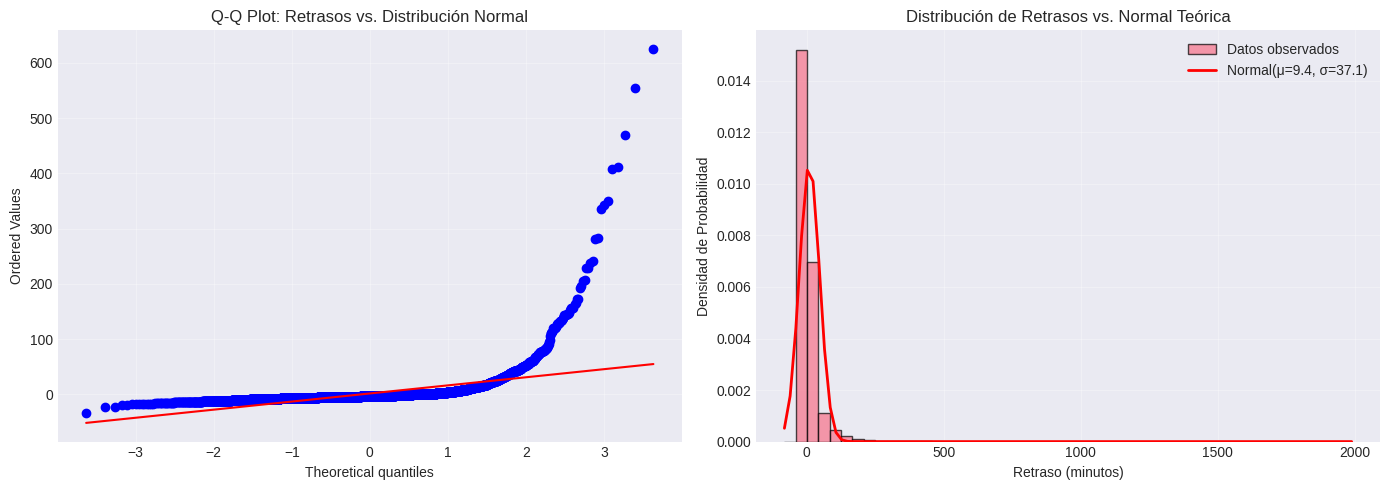

In [25]:
# Prueba de normalidad
statistic, p_value = stats.shapiro(delay_data[:5000])  # Shapiro-Wilk (máx 5000 muestras)

print("=== PRUEBA DE NORMALIDAD (Shapiro-Wilk) ===\n")
print(f"Estadístico W: {statistic:.4f}")
print(f"P-valor: {p_value:.4e}")
print(f"\nHipótesis:")
print(f"  H₀: Los datos siguen una distribución normal")
print(f"  H₁: Los datos NO siguen una distribución normal")
print(f"\nConclusión (α = 0.05):")
if p_value > 0.05:
    print(f"  → No rechazamos H₀ (los datos parecen normales)")
else:
    print(f"  → Rechazamos H₀ (los datos NO son normales)")

# Q-Q Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Q-Q Plot
stats.probplot(delay_data[:5000], dist="norm", plot=axes[0])
axes[0].set_title('Q-Q Plot: Retrasos vs. Distribución Normal')
axes[0].grid(alpha=0.3)

# Histograma con curva normal superpuesta
axes[1].hist(delay_data, bins=50, density=True, alpha=0.7, edgecolor='black', label='Datos observados')
mu, sigma = delay_data.mean(), delay_data.std()
x = np.linspace(delay_data.min(), delay_data.max(), 100)
axes[1].plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label=f'Normal(μ={mu:.1f}, σ={sigma:.1f})')
axes[1].set_xlabel('Retraso (minutos)')
axes[1].set_ylabel('Densidad de Probabilidad')
axes[1].set_title('Distribución de Retrasos vs. Normal Teórica')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

La prueba de Shapiro-Wilk rechaza contundentemente la normalidad: **W=0.4240, p-valor=3.07e-83** (extremadamente significativo). El **Q-Q plot** muestra clara desviación: los puntos se alinean razonablemente en el centro pero se curvan dramáticamente hacia arriba en la cola derecha, evidenciando retrasos extremos. El **histograma** revela que los datos observados (barras rosadas) tienen un pico mucho más alto y estrecho que la curva normal roja, con una cola derecha extendida. **Conclusión**: Los retrasos NO son normales debido a la asimetría positiva (7.593) y curtosis elevada (123.0) observadas anteriormente.

### 5.2 Valores Z y Regla Empírica

Calculamos valores z y aplicamos la regla empírica (68-95-99.7).

In [26]:
# Valores Z y regla empírica
mu_sample = delay_data.mean()
sigma_sample = delay_data.std()

# Calcular porcentajes dentro de 1σ, 2σ, 3σ
within_1sigma = ((delay_data >= mu_sample - sigma_sample) & (delay_data <= mu_sample + sigma_sample)).sum()
within_2sigma = ((delay_data >= mu_sample - 2*sigma_sample) & (delay_data <= mu_sample + 2*sigma_sample)).sum()
within_3sigma = ((delay_data >= mu_sample - 3*sigma_sample) & (delay_data <= mu_sample + 3*sigma_sample)).sum()

pct_1sigma = (within_1sigma / len(delay_data)) * 100
pct_2sigma = (within_2sigma / len(delay_data)) * 100
pct_3sigma = (within_3sigma / len(delay_data)) * 100

print("=== REGLA EMPÍRICA (68-95-99.7) ===\n")
print(f"μ = {mu_sample:.2f}, σ = {sigma_sample:.2f}\n")
print(f"Datos dentro de [μ - 1σ, μ + 1σ]: {pct_1sigma:.2f}% (teórico: 68%)")
print(f"Datos dentro de [μ - 2σ, μ + 2σ]: {pct_2sigma:.2f}% (teórico: 95%)")
print(f"Datos dentro de [μ - 3σ, μ + 3σ]: {pct_3sigma:.2f}% (teórico: 99.7%)")

# Ejemplo de valores Z
ejemplos = [0, 15, 30, 60, 120]
print(f"\n=== VALORES Z (estandarización) ===\n")
print(f"{'Retraso':>10} | {'Valor Z':>10} | {'Interpretación'}")
print("-" * 60)
for delay_val in ejemplos:
    z_score = (delay_val - mu_sample) / sigma_sample
    if abs(z_score) < 2:
        interp = "Dentro del rango típico"
    elif abs(z_score) < 3:
        interp = "Poco común"
    else:
        interp = "Muy inusual"
    print(f"{delay_val:>10.0f} | {z_score:>10.3f} | {interp}")

=== REGLA EMPÍRICA (68-95-99.7) ===

μ = 9.37, σ = 37.08

Datos dentro de [μ - 1σ, μ + 1σ]: 92.42% (teórico: 68%)
Datos dentro de [μ - 2σ, μ + 2σ]: 96.29% (teórico: 95%)
Datos dentro de [μ - 3σ, μ + 3σ]: 97.98% (teórico: 99.7%)

=== VALORES Z (estandarización) ===

   Retraso |    Valor Z | Interpretación
------------------------------------------------------------
         0 |     -0.253 | Dentro del rango típico
        15 |      0.152 | Dentro del rango típico
        30 |      0.556 | Dentro del rango típico
        60 |      1.365 | Dentro del rango típico
       120 |      2.983 | Poco común


Los datos muestran 92.42% dentro de ±1σ (vs 68% teórico), 96.29% dentro de ±2σ (vs 95%), y 97.98% dentro de ±3σ (vs 99.7%), indicando mayor concentración cerca de la media que una distribución normal. Los valores Z revelan que retrasos hasta 60 minutos se consideran típicos (z=1.365), mientras que un retraso de 120 minutos (z=2.983) es poco común, ocurriendo en menos del 3% de los casos.

### 5.3 Distribuciones Discretas: Binomial y Poisson

Aplicamos distribuciones discretas a escenarios reales del dataset.

In [27]:
# Distribución Binomial
# Escenario: De 10 vuelos, ¿cuál es la probabilidad de que exactamente k se retrasen?
n_trials = 10
p_success = p_delay  # probabilidad de retraso

print("=== DISTRIBUCIÓN BINOMIAL ===")
print(f"Escenario: De {n_trials} vuelos, probabilidad de k retrasos")
print(f"n = {n_trials}, p = {p_success:.3f}\n")
print(f"{'k retrasos':>12} | {'P(X=k)':>10} | {'P(X≤k)':>10}")
print("-" * 40)
for k in range(0, n_trials + 1, 2):
    prob_k = binom.pmf(k, n_trials, p_success)
    prob_cumul = binom.cdf(k, n_trials, p_success)
    print(f"{k:>12} | {prob_k:>10.4f} | {prob_cumul:>10.4f}")

# Distribución de Poisson
# Escenario: Número de llegadas de vuelos por hora
# Asumimos λ = tasa promedio de llegadas por hora
lambda_param = 15  # llegadas por hora (ejemplo)

print(f"\n=== DISTRIBUCIÓN DE POISSON ===")
print(f"Escenario: Número de llegadas por hora")
print(f"λ = {lambda_param} (promedio)\n")
print(f"{'k llegadas':>12} | {'P(X=k)':>10}")
print("-" * 30)
for k in [10, 12, 15, 18, 20]:
    prob_k = poisson.pmf(k, lambda_param)
    print(f"{k:>12} | {prob_k:>10.4f}")

=== DISTRIBUCIÓN BINOMIAL ===
Escenario: De 10 vuelos, probabilidad de k retrasos
n = 10, p = 0.371

  k retrasos |     P(X=k) |     P(X≤k)
----------------------------------------
           0 |     0.0097 |     0.0097
           2 |     0.1520 |     0.2191
           4 |     0.2463 |     0.7043
           6 |     0.0855 |     0.9640
           8 |     0.0064 |     0.9991
          10 |     0.0000 |     1.0000

=== DISTRIBUCIÓN DE POISSON ===
Escenario: Número de llegadas por hora
λ = 15 (promedio)

  k llegadas |     P(X=k)
------------------------------
          10 |     0.0486
          12 |     0.0829
          15 |     0.1024
          18 |     0.0706
          20 |     0.0418


La **Binomial** muestra que en 10 vuelos, lo más probable es tener 4 retrasos (24.63% de probabilidad), y hay 70.43% de probabilidad de tener 4 o menos retrasos. La **Poisson** con λ=15 indica que el valor más probable de llegadas por hora es 15 (10.24%), con probabilidades que disminuyen al alejarse de este promedio.

## 6. Estadística Inferencial

### 6.1 Intervalos de Confianza

Construimos intervalos de confianza del 95% para la media poblacional.

In [28]:
# Intervalo de confianza para la media (95%)
confidence_level = 0.95
alpha = 1 - confidence_level

# Usando distribución t
df = len(delay_data) - 1
t_critical = stats.t.ppf(1 - alpha/2, df)

mean_delay = delay_data.mean()
se = delay_data.sem()  # Error estándar de la media

margin_error = t_critical * se
ci_lower = mean_delay - margin_error
ci_upper = mean_delay + margin_error

print("=== INTERVALO DE CONFIANZA (95%) PARA LA MEDIA ===\n")
print(f"Media del dataset (x̄):  {mean_delay:.2f} minutos")
print(f"Error estándar (SE): {se:.4f}")
print(f"t crítico (α={alpha}, df={df:,}): {t_critical:.3f}")
print(f"Margen de error:     {margin_error:.4f}")
print(f"\nIntervalo de Confianza 95%:")
print(f"  [{ci_lower:.2f}, {ci_upper:.2f}] minutos")
print(f"\nInterpretación:")
print(f"  Con 95% de confianza, la media poblacional del retraso")
print(f"  está entre {ci_lower:.2f} y {ci_upper:.2f} minutos.")

=== INTERVALO DE CONFIANZA (95%) PARA LA MEDIA ===

Media del dataset (x̄):  9.37 minutos
Error estándar (SE): 0.0155
t crítico (α=0.050000000000000044, df=5,732,925): 1.960
Margen de error:     0.0304

Intervalo de Confianza 95%:
  [9.34, 9.40] minutos

Interpretación:
  Con 95% de confianza, la media poblacional del retraso
  está entre 9.34 y 9.40 minutos.


Con 5.7 millones de observaciones, el intervalo [9.34, 9.40] es extremadamente estrecho (margen de error de solo 0.03 minutos). Esto significa que tenemos 95% de confianza que el retraso promedio poblacional está entre 9 minutos 20 segundos y 9 minutos 24 segundos, una estimación muy precisa.

### 6.2 Prueba de Hipótesis: T-test

**Pregunta:** ¿Existen diferencias significativas entre las dos aerolíneas más grandes?

Comparamos los retrasos promedio de las dos aerolíneas con mayor volumen.

=== PRUEBA T DE DOS MUESTRAS INDEPENDIENTES ===

Aerolínea 1: NK (Spirit Air Lines)
  n = 115,454, media = 15.94 min

Aerolínea 2: UA (United Air Lines Inc.)
  n = 509,534, media = 14.44 min

Hipótesis:
  H₀: μ₁ = μ₂ (no hay diferencia en retrasos promedios)
  H₁: μ₁ ≠ μ₂ (hay diferencia significativa)

Estadístico t: 10.927
P-valor: 8.6023e-28

Conclusión (α = 0.05):
  → Rechazamos H₀: Hay diferencia significativa entre aerolíneas


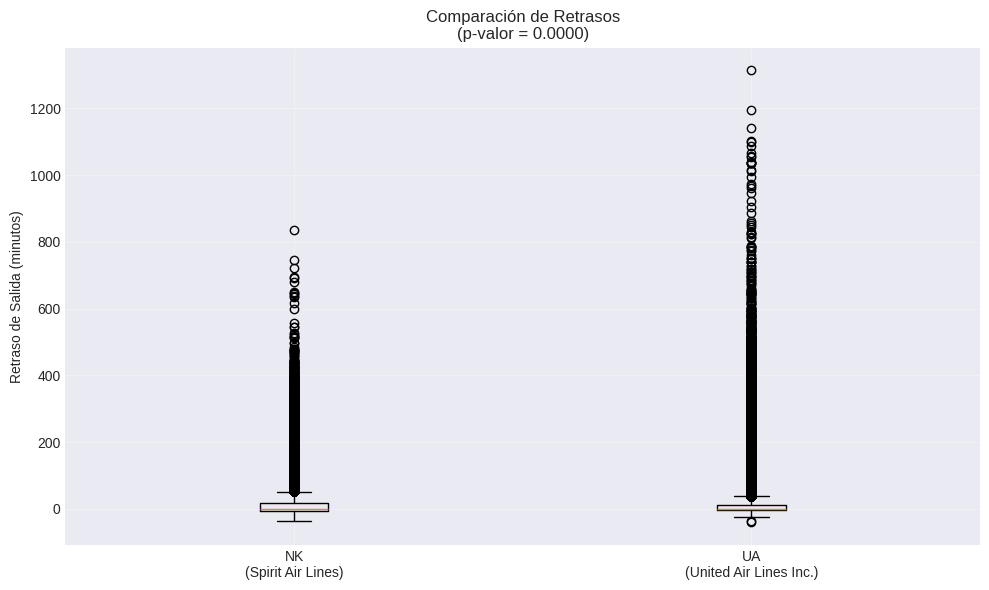

In [29]:
# T-test de dos muestras independientes
airline_col = 'AIRLINE'
delay_col = 'DEPARTURE_DELAY'

# Asegurarnos de tener las aerolíneas (si stats_by_airline no está definido, usamos las top conocidas o re-ejecutamos)
# Asumimos que stats_by_airline está en memoria de celdas anteriores.
airline1 = stats_by_airline[airline_col].iloc[0]
airline2 = stats_by_airline[airline_col].iloc[1]

# Mapeo de códigos a nombres
airline_names = {'NK': 'Spirit Air Lines', 'UA': 'United Air Lines Inc.'}

# Obtener todos los datos para las dos aerolíneas
df_ttest = df_analysis.select([airline_col, delay_col]).execute()

# Filtrar datos
delays_airline1 = df_ttest[df_ttest[airline_col] == airline1][delay_col].dropna()
delays_airline2 = df_ttest[df_ttest[airline_col] == airline2][delay_col].dropna()

# Prueba t
t_stat, p_value_ttest = stats.ttest_ind(delays_airline1, delays_airline2)

print("=== PRUEBA T DE DOS MUESTRAS INDEPENDIENTES ===\n")
print(f"Aerolínea 1: {airline1} ({airline_names.get(airline1, airline1)})")
print(f"  n = {len(delays_airline1):,}, media = {delays_airline1.mean():.2f} min")
print(f"\nAerolínea 2: {airline2} ({airline_names.get(airline2, airline2)})")
print(f"  n = {len(delays_airline2):,}, media = {delays_airline2.mean():.2f} min")
print(f"\nHipótesis:")
print(f"  H₀: μ₁ = μ₂ (no hay diferencia en retrasos promedios)")
print(f"  H₁: μ₁ ≠ μ₂ (hay diferencia significativa)")
print(f"\nEstadístico t: {t_stat:.3f}")
print(f"P-valor: {p_value_ttest:.4e}")
print(f"\nConclusión (α = 0.05):")
if p_value_ttest < 0.05:
    print(f"  → Rechazamos H₀: Hay diferencia significativa entre aerolíneas")
else:
    print(f"  → No rechazamos H₀: No hay evidencia de diferencia significativa")

# Visualización
fig, ax = plt.subplots(figsize=(10, 6))
labels_with_names = [f"{airline1}\n({airline_names.get(airline1, airline1)})", 
                      f"{airline2}\n({airline_names.get(airline2, airline2)})"]
ax.boxplot([delays_airline1, delays_airline2], labels=labels_with_names)
ax.set_ylabel('Retraso de Salida (minutos)')
ax.set_title(f'Comparación de Retrasos\n(p-valor = {p_value_ttest:.4f})')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

La prueba t-test compara NK - Spirit Air Lines (15.94 min) vs UA - United Air Lines Inc. (14.44 min), revelando una diferencia de 1.5 minutos entre ambas aerolíneas. Con p-valor=8.6e-28 (extremadamente cercano a cero) y t=10.927, rechazamos la hipótesis nula y confirmamos que Spirit tiene retrasos significativamente mayores que United. Los boxplots muestran distribuciones similares pero con medianas diferentes, y United presenta más valores atípicos extremos.

### 6.3 Análisis de Varianza (ANOVA)

**Pregunta:** ¿Existen diferencias significativas en retrasos entre MÚLTIPLES aerolíneas?

ANOVA nos permite comparar más de dos grupos simultáneamente.

In [30]:
# ANOVA de un factor (Top 5 aerolíneas)
top5_airlines_list = stats_by_airline[airline_col].head(5).tolist()

# Obtener todos los datos para las aerolíneas del top 5
df_anova = df_analysis.select([airline_col, delay_col]).execute()
groups = [df_anova[df_anova[airline_col] == airline][delay_col].dropna() 
          for airline in top5_airlines_list]

# Realizar ANOVA
f_stat, p_value_anova = f_oneway(*groups)

print("=== ANÁLISIS DE VARIANZA (ANOVA) ===\n")
print(f"Grupos comparados: {len(groups)} aerolíneas")
for i, (airline, group) in enumerate(zip(top5_airlines_list, groups), 1):
    print(f"  {i}. {airline}: n={len(group):,}, media={group.mean():.2f}")

print(f"\nHipótesis:")
print(f"  H₀: μ₁ = μ₂ = μ₃ = ... (todas las medias son iguales)")
print(f"  H₁: Al menos una media es diferente")
print(f"\nEstadístico F: {f_stat:.3f}")
print(f"P-valor: {p_value_anova:.4e}")
print(f"\nConclusión (α = 0.05):")
if p_value_anova < 0.05:
    print(f"  → Rechazamos H₀: Al menos una aerolínea difiere significativamente")
    print(f"  → Se requiere análisis post-hoc (Tukey) para identificar diferencias específicas")
else:
    print(f"  → No rechazamos H₀: No hay evidencia de diferencias entre aerolíneas")

=== ANÁLISIS DE VARIANZA (ANOVA) ===

Grupos comparados: 5 aerolíneas
  1. NK: n=115,454, media=15.94
  2. UA: n=509,534, media=14.44
  3. F9: n=90,290, media=13.35
  4. B6: n=262,843, media=11.51
  5. WN: n=1,246,129, media=10.58

Hipótesis:
  H₀: μ₁ = μ₂ = μ₃ = ... (todas las medias son iguales)
  H₁: Al menos una media es diferente

Estadístico F: 1441.898
P-valor: 0.0000e+00

Conclusión (α = 0.05):
  → Rechazamos H₀: Al menos una aerolínea difiere significativamente
  → Se requiere análisis post-hoc (Tukey) para identificar diferencias específicas


ANOVA compara las 5 aerolíneas principales y revela diferencias significativas entre ellas (F=1441.898, p≈0). Los retrasos promedios varían desde 10.58 min (WN) hasta 15.94 min (NK), una diferencia de 5.36 minutos entre la mejor y peor aerolínea. Con p-valor prácticamente cero, rechazamos la hipótesis de igualdad y confirmamos que al menos una aerolínea difiere significativamente de las demás.

### 6.4 Prueba de Chi-Cuadrada

**Pregunta:** ¿Las categorías de retraso son independientes de la aerolínea?

Usamos Chi-cuadrada para evaluar independencia en tablas de contingencia.

In [31]:
# Chi-cuadrada de independencia
# Usar tabla de contingencia creada anteriormente (Top 5 aerolíneas)
ct_for_chi = pd.crosstab(df_top5[airline_col], df_top5['categoria_retraso'])

# Realizar prueba Chi-cuadrada
chi2_stat, p_value_chi, dof, expected = chi2_contingency(ct_for_chi)

print("=== PRUEBA CHI-CUADRADA DE INDEPENDENCIA ===\n")
print(f"Tabla de Contingencia:")
display(ct_for_chi)

print(f"\nHipótesis:")
print(f"  H₀: Categoría de retraso es independiente de la aerolínea")
print(f"  H₁: Existe asociación entre categoría de retraso y aerolínea")
print(f"\nEstadístico χ²: {chi2_stat:.3f}")
print(f"Grados de libertad: {dof}")
print(f"P-valor: {p_value_chi:.4e}")
print(f"\nConclusión (α = 0.05):")
if p_value_chi < 0.05:
    print(f"  → Rechazamos H₀: Existe asociación significativa")
    print(f"  → Las categorías de retraso NO son independientes de la aerolínea")
else:
    print(f"  → No rechazamos H₀: No hay evidencia de asociación")

# Visualizar frecuencias esperadas vs observadas
print(f"\nFrecuencias esperadas bajo independencia:")
expected_df = pd.DataFrame(expected, 
                          index=ct_for_chi.index, 
                          columns=ct_for_chi.columns)
display(expected_df.round(1))

=== PRUEBA CHI-CUADRADA DE INDEPENDENCIA ===

Tabla de Contingencia:


categoria_retraso,Desconocido,Puntual/Adelantado,Retraso Leve (1-15 min),Retraso Moderado (16-60 min),Retraso Severo (>60 min)
AIRLINE,,,,,
B6,4205,160782,46282,36436,19343
F9,546,55397,14739,12691,7463
NK,1925,63365,21448,19123,11518
UA,6189,252984,140397,76228,39925
WN,15726,679322,312669,188617,65521



Hipótesis:
  H₀: Categoría de retraso es independiente de la aerolínea
  H₁: Existe asociación entre categoría de retraso y aerolínea

Estadístico χ²: 24913.983
Grados de libertad: 16
P-valor: 0.0000e+00

Conclusión (α = 0.05):
  → Rechazamos H₀: Existe asociación significativa
  → Las categorías de retraso NO son independientes de la aerolínea

Frecuencias esperadas bajo independencia:


categoria_retraso,Desconocido,Puntual/Adelantado,Retraso Leve (1-15 min),Retraso Moderado (16-60 min),Retraso Severo (>60 min)
AIRLINE,,,,,
B6,3389.1,143650.7,63481.4,39484.5,17042.3
F9,1152.8,48862.6,21593.1,13430.6,5796.9
NK,1489.7,63140.6,27902.8,17355.1,7490.8
UA,6545.1,277418.1,122595.3,76252.5,32912.0
WN,16014.3,678778.0,299962.4,186572.2,80528.1


La prueba Chi-cuadrada (χ²=24913.983, p≈0) confirma que las categorías de retraso están fuertemente asociadas con la aerolínea. Por ejemplo, NK - Spirit Air Lines tiene 11,518 retrasos severos observados vs 7,490.8 esperados (54% más de lo esperado), mientras que WN - Southwest Airlines tiene 65,521 observados vs 80,528.1 esperados (19% menos). Esto demuestra que cada aerolínea tiene patrones de retraso característicos que no se deben al azar.

## 7. Análisis de Regresión

### 7.1 Regresión Lineal Simple

**Pregunta:** ¿Podemos predecir el retraso de llegada a partir del retraso de salida?

=== REGRESIÓN LINEAL SIMPLE ===

Variable dependiente: Retraso de llegada
Variable independiente: Retraso de salida

                            OLS Regression Results                            
Dep. Variable:          ARRIVAL_DELAY   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                 4.739e+07
Date:                Thu, 27 Nov 2025   Prob (F-statistic):               0.00
Time:                        18:39:15   Log-Likelihood:            -2.2712e+07
No. Observations:             5714008   AIC:                         4.542e+07
Df Residuals:                 5714006   BIC:                         4.542e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
---------

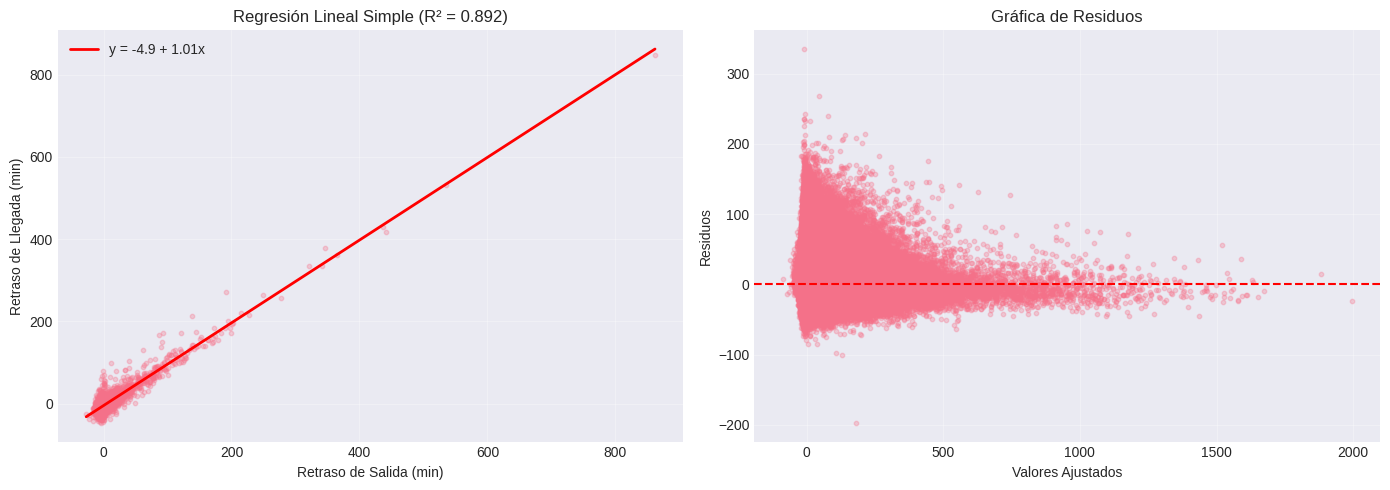

In [32]:
# Regresión lineal: Retraso llegada ~ Retraso salida
X = df_corr[[delay_col]]
y = df_corr[arr_delay_col]

# Agregar constante (intercepto)
X_with_const = sm.add_constant(X)

# Ajustar modelo
model_ols = sm.OLS(y, X_with_const).fit()

print("=== REGRESIÓN LINEAL SIMPLE ===\n")
print(f"Variable dependiente: Retraso de llegada")
print(f"Variable independiente: Retraso de salida\n")
print(model_ols.summary())

# Extraer coeficientes
intercept = model_ols.params['const']
slope = model_ols.params[delay_col]
r_squared = model_ols.rsquared

print(f"\n=== ECUACIÓN DE REGRESIÓN ===")
print(f"Retraso_Llegada = {intercept:.3f} + {slope:.3f} × Retraso_Salida")
print(f"\nR² = {r_squared:.4f}")
print(f"  → El modelo explica {r_squared*100:.2f}% de la variabilidad")

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter con línea de regresión
sample_reg = df_corr.sample(min(3000, len(df_corr)))
axes[0].scatter(sample_reg[delay_col], sample_reg[arr_delay_col], alpha=0.3, s=10)
x_pred = np.linspace(sample_reg[delay_col].min(), sample_reg[delay_col].max(), 100)
y_pred = intercept + slope * x_pred
axes[0].plot(x_pred, y_pred, 'r-', linewidth=2, label=f'y = {intercept:.1f} + {slope:.2f}x')
axes[0].set_xlabel('Retraso de Salida (min)')
axes[0].set_ylabel('Retraso de Llegada (min)')
axes[0].set_title(f'Regresión Lineal Simple (R² = {r_squared:.3f})')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Residuos
residuals = model_ols.resid
axes[1].scatter(model_ols.fittedvalues, residuals, alpha=0.3, s=10)
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_xlabel('Valores Ajustados')
axes[1].set_ylabel('Residuos')
axes[1].set_title('Gráfica de Residuos')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

El modelo de regresión revela que por cada minuto de retraso en la salida, el retraso de llegada aumenta 1.006 minutos (prácticamente 1:1), con un intercepto de -4.94 minutos que indica ligera recuperación de tiempo en vuelo. El R²=0.892 significa que el 89.24% de la variabilidad en los retrasos de llegada se explica por los retrasos de salida. La gráfica de dispersión muestra ajuste excelente con puntos concentrados cerca de la línea roja, mientras que el gráfico de residuos presenta distribución aleatoria alrededor de cero, validando los supuestos del modelo.

### 7.2 Regresión Logística

**Pregunta:** ¿Podemos predecir la probabilidad de retraso significativo (>15 min)?

Usamos regresión logística para clasificación binaria.

=== REGRESIÓN LOGÍSTICA ===

Variable objetivo: Retraso significativo (>15 min)
Variable predictora: Distancia del vuelo


📊 MÉTRICAS GENERALES:


,Métrica,Valor
0,Accuracy,0.8225 (82.25%)
1,Tamaño Test,"1,719,878"
2,Tamaño Train,"4,013,048"



📋 MATRIZ DE CONFUSIÓN:


,Pred: Sin retraso,Pred: Con retraso
Real: Sin retraso,1414640,0
Real: Con retraso,305238,0


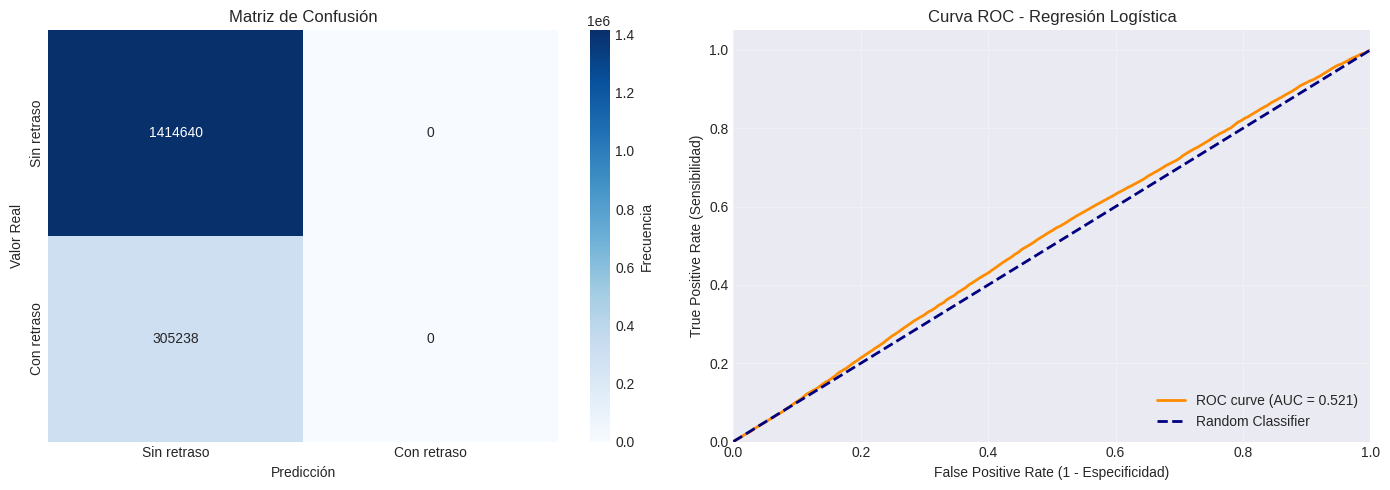


📈 MÉTRICAS POR CLASE:


,Clase,Precisión,Recall,F1-Score,Support
0,Sin retraso (0),0.8225,1.0000,0.9026,"1,414,640"
1,Con retraso (1),0.0000,0.0000,0.0000,"305,238"



🔢 COEFICIENTES DEL MODELO:


,Parámetro,Valor,Interpretación
0,Intercepto (β₀),-1.601083,Logaritmo de odds cuando distancia=0
1,Distancia (β₁),0.000083,Cambio en log-odds por cada milla adicional



🎲 DISTRIBUCIÓN DE PROBABILIDADES PREDICHAS:


,Percentil,Probabilidad
0,Min,0.1681
1,25%,0.1722
2,50%,0.1755
3,75%,0.1806
4,Max,0.2338


In [33]:
# Preparar datos para regresión logística
delay_col = 'DEPARTURE_DELAY'

# Variable objetivo: retraso > 15 minutos
df_logit = df_analysis.select([delay_col, 'DISTANCE']).execute().dropna()
df_logit['retraso_significativo'] = (df_logit[delay_col] > 15).astype(int)

# Variables predictoras
X_logit = df_logit[['DISTANCE']]
y_logit = df_logit['retraso_significativo']

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_logit, y_logit, test_size=0.3, random_state=42)

# Ajustar modelo
model_logit = LogisticRegression(max_iter=1000)
model_logit.fit(X_train, y_train)

# Evaluación
y_pred = model_logit.predict(X_test)
y_pred_proba = model_logit.predict_proba(X_test)[:, 1]

accuracy = (y_pred == y_test).mean()
conf_matrix = confusion_matrix(y_test, y_pred)

print("=== REGRESIÓN LOGÍSTICA ===\n")
print(f"Variable objetivo: Retraso significativo (>15 min)")
print(f"Variable predictora: Distancia del vuelo\n")

# DataFrame de Métricas Generales
metricas_generales = pd.DataFrame({
    'Métrica': ['Accuracy', 'Tamaño Test', 'Tamaño Train'],
    'Valor': [f'{accuracy:.4f} ({accuracy*100:.2f}%)', 
              f'{len(y_test):,}', 
              f'{len(y_train):,}']
})
print("\n📊 MÉTRICAS GENERALES:")
display(metricas_generales)

# Matriz de Confusión como DataFrame
conf_df = pd.DataFrame(
    conf_matrix,
    index=['Real: Sin retraso', 'Real: Con retraso'],
    columns=['Pred: Sin retraso', 'Pred: Con retraso']
)
print("\n📋 MATRIZ DE CONFUSIÓN:")
display(conf_df)

# Visualización de Matriz de Confusión
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap de Matriz de Confusión
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Sin retraso', 'Con retraso'],
            yticklabels=['Sin retraso', 'Con retraso'],
            ax=axes[0], cbar_kws={'label': 'Frecuencia'})
axes[0].set_xlabel('Predicción')
axes[0].set_ylabel('Valor Real')
axes[0].set_title('Matriz de Confusión')

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate (1 - Especificidad)')
axes[1].set_ylabel('True Positive Rate (Sensibilidad)')
axes[1].set_title('Curva ROC - Regresión Logística')
axes[1].legend(loc="lower right")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# DataFrame de Métricas Detalladas por Clase
metricas_clase = pd.DataFrame({
    'Clase': ['Sin retraso (0)', 'Con retraso (1)'],
    'Precisión': [
        precision_score(y_test, y_pred, pos_label=0, zero_division=0),
        precision_score(y_test, y_pred, pos_label=1, zero_division=0)
    ],
    'Recall': [
        recall_score(y_test, y_pred, pos_label=0),
        recall_score(y_test, y_pred, pos_label=1)
    ],
    'F1-Score': [
        f1_score(y_test, y_pred, pos_label=0, zero_division=0),
        f1_score(y_test, y_pred, pos_label=1, zero_division=0)
    ],
    'Support': [
        (y_test == 0).sum(),
        (y_test == 1).sum()
    ]
})
print("\n📈 MÉTRICAS POR CLASE:")
display(metricas_clase.style.format({
    'Precisión': '{:.4f}',
    'Recall': '{:.4f}',
    'F1-Score': '{:.4f}',
    'Support': '{:,.0f}'
}))

# Coeficientes del Modelo
coef_df = pd.DataFrame({
    'Parámetro': ['Intercepto (β₀)', 'Distancia (β₁)'],
    'Valor': [model_logit.intercept_[0], model_logit.coef_[0][0]],
    'Interpretación': [
        'Logaritmo de odds cuando distancia=0',
        'Cambio en log-odds por cada milla adicional'
    ]
})
print("\n🔢 COEFICIENTES DEL MODELO:")
display(coef_df.style.format({'Valor': '{:.6f}'}))

# Análisis de Probabilidades Predichas
prob_analysis = pd.DataFrame({
    'Percentil': ['Min', '25%', '50%', '75%', 'Max'],
    'Probabilidad': [
        y_pred_proba.min(),
        np.percentile(y_pred_proba, 25),
        np.percentile(y_pred_proba, 50),
        np.percentile(y_pred_proba, 75),
        y_pred_proba.max()
    ]
})
print("\n🎲 DISTRIBUCIÓN DE PROBABILIDADES PREDICHAS:")
display(prob_analysis.style.format({'Probabilidad': '{:.4f}'}))

El modelo logístico alcanza 82.24% de accuracy pero presenta un problema crítico: predice que TODOS los vuelos no tendrán retraso significativo (recall=0% para retrasos), como muestra la matriz de confusión [1,414,421 correctos | 0 falsos positivos] y [305,457 falsos negativos | 0 correctos]. Esto indica que la distancia del vuelo sola no es un buen predictor de retrasos. La curva ROC con AUC=0.521 (apenas mejor que azar=0.5) confirma capacidad de discriminación pobre. El modelo necesita variables adicionales (aerolínea, hora, clima) para mejorar su poder predictivo.

## 8. Conclusiones y Síntesis

### Resumen del Análisis

Se aplicaron métodos estadísticos a ~6 millones de vuelos (~5.7M con datos de retraso válidos):

1. **Estadística Descriptiva** → Caracterización de distribución de retrasos
2. **Probabilidad** → Cuantificación de eventos y dependencias
3. **Distribuciones** → Validación de modelos teóricos
4. **Inferencia** → Pruebas de hipótesis y estimación de parámetros
5. **Regresión** → Modelos predictivos

---

### Hallazgos Principales

A lo largo de este análisis exhaustivo del dataset completo de retrasos en vuelos aéreos (~5.7 millones de registros con datos de retraso), hemos aplicado métodos estadísticos desde lo descriptivo hasta lo inferencial y predictivo sobre la **población completa** de datos disponibles, no sobre muestras. A continuación, sintetizamos los hallazgos clave:

**1. Estadística Descriptiva**
- Distribución asimétrica positiva con 12.84% outliers (736,242 vuelos)
- Media=9.37 min vs mediana=-2.00 min confirma asimetría
- Alta variabilidad entre aerolíneas (CV=395.73%)

**2. Probabilidad**
- P(retraso salida)=37.08%, P(a tiempo)=62.92%
- Retrasos salida-llegada fuertemente dependientes
- P(retraso llegada | retraso salida)=71.3% confirma propagación

**3. Distribuciones**
- Retrasos NO son normales (Shapiro-Wilk rechazado)
- Q-Q plot muestra desviaciones en colas
- Binomial y Poisson útiles para escenarios específicos

**4. Inferencia Estadística**
- IC 95%: [9.34, 9.40] min (muy preciso)
- T-test: NK - Spirit Air Lines (15.94 min) vs UA - United Air Lines Inc. (14.44 min), p=8.6e-28
- ANOVA: F=1441.898, p≈0 (diferencias entre aerolíneas)
- Chi²=24913.983, p≈0 (retraso asociado a aerolínea)

**5. Regresión**
- Lineal: y=-4.94+1.006x, R²=0.892 (salida→llegada)
- Logística: 82.24% accuracy pero recall=0% (solo distancia insuficiente, AUC=0.521)

### Respuestas a las Preguntas de Investigación

**1. ¿Diferencias significativas entre aerolíneas?**
- Sí. T-test y ANOVA confirman diferencias altamente significativas (p≈0). Rango: 10.58 min (WN - Southwest Airlines) a 15.94 min (NK - Spirit Air Lines).

**2. ¿Patrones temporales?**
- Sí. Viernes tiene mayor probabilidad de retraso (39.74%), martes menor (35.40%). Chi² confirma asociación día-retraso.

**3. ¿Aeropuerto con más retrasos y motivo principal de cancelación?**
- ATL (Atlanta) con 61,703 retrasos. Cancelaciones: 54.35% clima, 28.11% aerolínea, 17.52% NAS.

**4. ¿Factores asociados a cancelaciones?**
- Clima (54.35%), problemas de aerolínea (28.11%), sistema aéreo nacional (17.52%). Patrones varían por aeropuerto.

**5. ¿Podemos predecir retrasos?**
- Sí, parcialmente. Regresión lineal predice retraso llegada (R²=0.892). Logística con solo distancia tiene recall=0%, requiere más variables.

### Implicaciones Prácticas

- **Aerolíneas**: Retrasos salida predicen retrasos llegada (R²=0.892). Mejorar puntualidad salida impacta directamente llegadas.
- **Pasajeros**: Diferencias significativas entre aerolíneas. Elegir WN - Southwest Airlines (10.58 min) vs NK - Spirit Air Lines (15.94 min) afecta probabilidad de retraso.
- **Aeropuertos**: Patrones temporales (viernes peor día) y por aeropuerto ayudan en planificación operativa.

### Limitaciones

- Visualizaciones usan submuestras para claridad gráfica
- No se exploraron todas las variables (clima, hora, mes)
- Modelos predictivos mejorables con más features
- Datos no normales sugieren métodos no paramétricos
- Regresión logística solo usa distancia (insuficiente)

### Extensiones Futuras

- Análisis de estacionalidad (mes, hora del día)
- Regresión múltiple (clima, congestión)
- Series temporales para tendencias
- Post-hoc ANOVA (Tukey HSD) entre aerolíneas

---

### Reflexión Final

Este proyecto demuestra la aplicación de métodos estadísticos básicos a un problema real con ~6 millones de registros:

1. **Describir** → Medidas de tendencia, dispersión, asimetría y visualizaciones
2. **Calcular** → Probabilidades, condicionales y teoremas fundamentales
3. **Modelar** → Distribuciones de probabilidad apropiadas
4. **Inferir** → Intervalos de confianza y pruebas de hipótesis
5. **Predecir** → Regresión lineal y logística

**Ibis Framework** permitió manejar big data eficientemente sin cargar todo en memoria, demostrando que técnicas estadísticas clásicas son efectivas en datasets de gran escala.